### Machine Learning for Systems & Control 5SC28 2023-2024

# Exercise set for Lecture 4 and 5: Gaussian Processes

## Table of contents

1. <a href="#Exercise-1:-Gaussian-Processes-for-dummies">Exercise 1: Introduction to Gaussian Processes</a>
2. <a href="#Exercise-2:-Choosing-a-good-prior-distribution-(i.e.-kernel-hyperparameter-optimization)">Exercise 2: Choosing a good prior distribution (i.e. kernel hyperparameter optimization)</a>
3. <a href="#Exercise-3:-Using-sklearn-GP">Exercise 3: Using sklearn GP</a>
4. <a href="#(demo)-Exercise-4:-Designing-custom-Kernels">(demo) Exercise 4: Designing custom Kernels</a>
5. <a href="#Exercise-5:-NARX-GP">Exercise 5: NARX GP</a>
6. <a href="#Exercise-6:-Bayesian-optimization">Exercise 6: Bayesian optimization</a>
6. <a href="#Exercise-7:-Sparse-Gaussian-Processes">Exercise 7: Sparse Gaussian Processes</a>

In this exercise set, you will implement your own Gaussian Process-based estimator, explore its properties and how this approach can be succesfully deployed in practice. 

## Exercise 1: Intorduction to Gaussian Processes

### Exercise 1.1: A GP with two points

A univariate Gaussian distribution is given by

$$p(y) = N(y|\bar{y}, \sigma_y) = \frac{1}{\sigma_y \sqrt{2 \pi}} \exp \left (-\frac{(y-\bar{y})^2}{2 \sigma_y^2} \right)$$

where $\bar{y}$ is the mean and $ \sigma_y$ the stardard deviation of the distribution.

This distribution can be generalized to multiple variables with as a [multivariate Gaussian distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). For instance, a multivariate Gaussian with two variables is given by 

$$
p(y_1, y_2) = \mathcal{N}(y| \bar{y}, \Sigma) =  (2 \pi)^{-\frac{2}{2}} \det ( \Sigma)^{-\frac{1}{2}} \exp \left (-\frac{1}{2} (y-\bar{y})^\top \Sigma^{-1} (y-\bar{y}) \right) \\$$
where 
$$ y = [y_1^\top, y_2^\top]^\top \\
\bar{y} = [\bar{y}_1^\top, \bar{y}_2^\top]^\top \\
\Sigma = \begin{pmatrix}
\Sigma_{y_1, y_1} & \Sigma_{y_1, y_2}\\ 
\Sigma_{y_1, y_2} & \Sigma_{y_2, y_2}
\end{pmatrix}
$$

with $\Sigma$ the covariance matrix which is required to be a positive definite matrix (i.e. $(y-\bar{y})^\top \Sigma (y-\bar{y}) > 0$ for all $y \neq \bar{y}$)


**a)** Why is positive definiteness of $\Sigma$ required for a multivariate gaussian distribution to be valid?


*tip: what happens to the normalization integral? $\int \exp \left (-\frac{1}{2} (y-\bar{y})^\top \Sigma^{-1} (y-\bar{y}) \right) dy$.*

**Answer a):** If $\Sigma$ is not positive definite then $\Sigma^{-1}$ is also not positive definate. Then, it is possible to find a $y \neq \bar{y}$ such that $(y-\bar{y})^\top \Sigma^{-1} (y-\bar{y}) \leq 0$ which results in the integral $\int \exp \left (-\frac{1}{2} (y-\bar{y})^\top \Sigma^{-1} (y-\bar{y}) \right) dy$ being indefinite. The resulting function will not be symmetric, hence, it cannot be a valid probability distribution.

**b)** $\Sigma_{y_1,y_1}$ is the variance of the first variable. However, how can we interpret the off-diagonal terms $\Sigma_{y_1,y_2}$? For this question use the cell below where a multi-variate Gaussian is sampled for $\bar{y} = 0$ and 
$
\Sigma = \begin{pmatrix}
1& \Sigma_{y_1, y_2}\\ 
\Sigma_{y_1, y_2} & 1
\end{pmatrix}
$ where you can set a list of off-diagonals $\Sigma_{y_1, y_2}$ given by `offdias`. Note that $-1= -\Sigma_{y_1,y_1} < \Sigma_{y_1, y_2} < \Sigma_{y_1,y_1} = 1$ is required for $\Sigma$ to be positive definite.

**Answer b):** For $\Sigma_{y_1, y_2} = 0$ there is no relation between $y_1$ and $y_2$ whereas if $\Sigma_{y_1, y_2} \approx \Sigma_{y_1,y_1} = 1$, then there is a strong linear relationship or in other words, $y_1$ and $y_2$ are strongly correlated. Lastly, if  $\Sigma_{y_1, y_2} \approx -\Sigma_{y_1,y_1} = -1$ then there is a strong negative linear relationship or in other words, $y_1$ and $y_2$ are strongly negatively correlated. Hence, $\Sigma_{y_1, y_2}$ can be intepreted as the covariance between sample $y_1$ and $y_2$ and $\Sigma_{y_1, y_2}/\Sigma_{y_1, y_1}$ the correlation between the two variables.

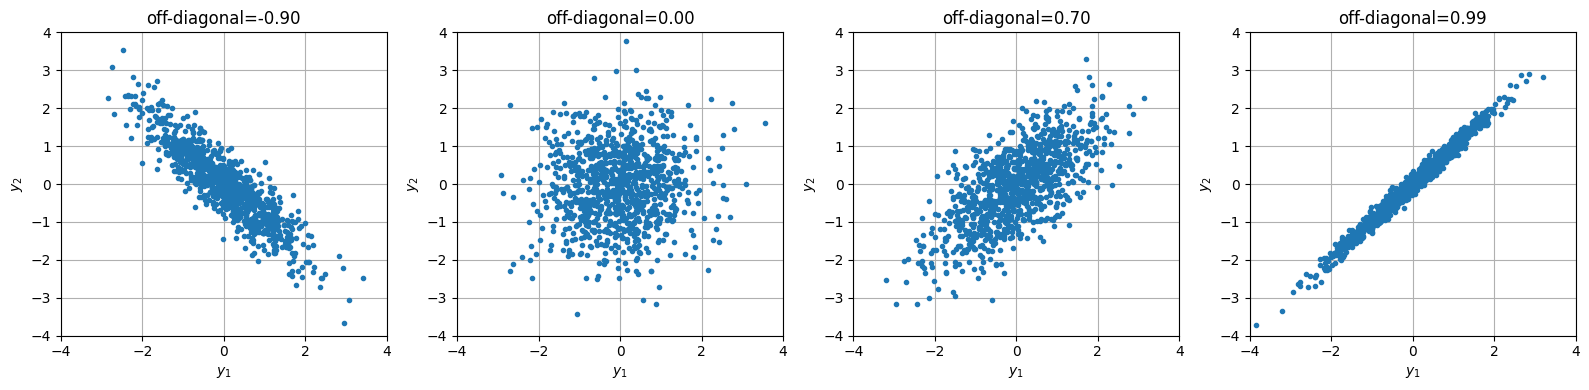

In [1]:
import numpy as np
from matplotlib import pyplot as plt

#give a list of off diagonals here
offdias = [-0.9, 0, 0.7, 0.99] #b=)

plt.figure(figsize=(4*len(offdias),4))
for i,offdia in enumerate(offdias, start=1):
    
    mean_array = np.array([0,0])
    covariance_matrix = np.array([[1,offdia],
                                  [offdia, 1]])

    y_samples = np.random.multivariate_normal(mean_array, covariance_matrix, size=1000)
    #y_samples is a array of shape (N_samples, N_variables=2)
    y1_samples = y_samples[:,0]
    y2_samples = y_samples[:,1]

    
    plt.subplot(1,len(offdias),i)
    plt.plot(y1_samples, y2_samples, '.')
    plt.xlim(-4,4)
    plt.grid()
    plt.ylim(-4,4)
    plt.title(f'off-diagonal={offdia:.2f}')
    plt.xlabel('$y_1$')
    plt.ylabel('$y_2$')
plt.tight_layout()
plt.show()

To better understand a Gaussian process, one can recognize that if $y_2$ is given then it will give information about $y_1$ if $\Sigma_{y_1,y_2} \neq 0$.

**c)** To see the implications, derive $p(y_1| y_2)$ for $\bar{y} = 0$ and $\Sigma = \begin{pmatrix}
\sigma & r\\ 
r & \sigma
\end{pmatrix}$

*Tip: use Bayes' Theorem ($p(y_1| y_2) p(y_2) = p(y_1,y_2)$) and Mathematica/Wolfram Alpha to compute the integrals you encounter in your calculations*

*Tip: the matrices based joint distribution can be written as $$p(y_1, y_2) \sim \exp \left(\frac{-2 r^2 y_1 y_2+\sigma ^2 y_1^2+\sigma ^2 y_2^2}{2 r^4-2 \sigma ^4}\right)$$*

**Answer c):** The probability distribution is given by $$p(y_1, y_2) \sim \exp \left(\frac{-2 r^2 y_1 y_2+\sigma ^2 y_1^2+\sigma ^2 y_2^2}{2 r^4-2 \sigma ^4}\right)$$ than using Bayes' Theorem we know that $$p(y_1| y_2)  = \frac{p(y_1,y_2)}{p(y_2)} = \frac{p(y_1,y_2)}{\int p(y_1, y_2) dy_1}$$ Thus $$p(y_1| y_2)  = \frac{p(y_1,y_2)}{p(y_2)} = \frac{ \exp\left(\frac{-2 r^2 y_1 y_2+\sigma ^2 y_1^2+\sigma ^2 y_2^2}{2 r^4-2 \sigma ^4}\right)}{\int  \exp \left(\frac{-2 r^2 y_1 y_2+\sigma ^2 y_1^2+\sigma ^2 y_2^2}{2 r^4-2 \sigma ^4}\right) dy_1}$$ which gives $$p(y_1|y_2) = \sqrt{\frac{\sigma ^2}{(2 \pi ) \left(\sigma ^4-r^4\right)}} \exp \left ( {-\frac{\left(y_1-\frac{r^2 y_2}{\sigma ^2}\right){}^2}{\frac{2 \left(\sigma ^4-r^4\right)}{\sigma ^2}}} \right )$$ This is again a Gaussian, but now univariate distribution: $$p(y_1|y_2) = \frac{1}{\tilde{\sigma} \sqrt{2 \pi}} \exp \left (-\frac{(y_1-\tilde{\bar{y}}_1)^2}{2 \tilde{\sigma}^2} \right)$$ $$\tilde{\sigma}^2 = \frac{\sigma ^4-r^4}{\sigma ^2}$$ $$\tilde{\bar{y}}_1 = \frac{r^2 y_2}{\sigma ^2}$$

We call $p(y_1, y_2)$ the prior distribution and $p(y_1|y_2)$ the posterior distribution after it has been updated with measurement information $y_2$. 


This is an interesting result, since, this allows us to compute (refine) the probability distribution of an output given some observations. Next, we will generalize this results for a set of observations. 

### Exercise 1.2: A GP with many points

The multi-variate Gaussian distribution is given by

$$
p(y) = \mathcal{N}(y| \bar{y}, \Sigma)\\
y = [y_1^\top, y_2^\top, y_3^\top,...,y_N^\top]^\top \\
\bar{y} = [\bar{y}_1^\top, \bar{y}_2^\top, \bar{y}_3^\top,...,\bar{y}_N^\top]^\top \\
\Sigma = \begin{pmatrix}
\Sigma_{y_1, y_1} & \Sigma_{y_1, y_2} & \cdots & \Sigma_{y_1, y_N} \\ 
\Sigma_{y_2, y_1} & \Sigma_{y_2, y_2} & \cdots & \Sigma_{y_2, y_N} \\
\vdots  & \vdots  & \ddots  & \vdots  \\ 
\Sigma_{y_N, y_1} & \Sigma_{y_N, y_2} & \cdots & \Sigma_{y_N, y_N}
\end{pmatrix}
$$

However, if $y$ corresponds to observations of a single random variable, then this is not very useful as it treats every observation separately, needing $N$ means and $N(N+1)/2$ covariance matrix terms. To simplify this representation, assume that there is already some related information available. For example; if $y_i$ would be a temperature measurement then $x_i$ could be the time of day that the measurement was or will be made.

Assume now that there exist functions which parameterize the mean and the covariance terms as;
$$\bar{y}_i = \mu(x_i)\\
\Sigma_{y_i, y_j} = k(x_i, x_j)
$$ 

which thus defines a prior distribution as

$$p(Y) = \mathcal{N} ( Y| \mu(X), k(X, X))$$

where

$$\mu(X) = [\mu(x_1), \mu(x_2), ..., \mu(x_N)]^\top$$

$$k(X,X) = \begin{pmatrix}
k(x_1,x_1) & k(x_1,x_2) & \cdots & k(x_1,x_N) \\ 
k(x_2,x_1)& k(x_2,x_2) & \cdots & k(x_2,x_N) \\
\vdots  & \vdots  & \ddots  & \vdots  \\ 
k(x_N,x_1) & k(x_N,x_2) & \cdots & k(x_N,x_N)
\end{pmatrix}$$

This does define a multi-variate Gaussian Process distribution as a prior. You will explore the properties of this prior in the next question. 

**d)** A very common parameterization of the kernel is the radial basis function kernel of the form 
$$
k(x_i, x_j) = \exp \left ( \frac{(x_i - x_j)^2}{2 \sigma_l^2} \right ).
$$
where $\sigma_l$ is called the kernel width or scale length of the kernel. Implement this function `kernel_RBF` for a given array of points as $k(X,X)$. 

*tip: use `np.exp`*

**e)** Compute the `covariance_matrix` and `mean_array` in the cell below and try out multiple kernel widths and mean functions. What is the general behaviour of the prior distributions and how does it depend on the kernel width and mean function? 

**Answer e):** The mean function is the mean of the prior distribution. The kernel width regulates the smoothness of the prior (small kernel width = fast changing values, big kernel width = slow changing values)

**f)** How can this implication of the kernel width on the prior smoothness be explained based on the covariance interpretation of the off-diagonal terms?

*Tip: use the kernel shape below*

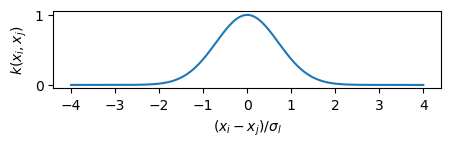

*Tip: look back at Question b)*

**Answer f):** If the difference between neighboring points is $|x_i - x_j| < \sigma_l$, then the kernel $k(x_i, x_j) \approx k(x_i, x_i) = 1$, which implies that there is a high covariance between $y_i$ and $y_j$ (and a corrolation of 1). This, then implies that $y_i$ and $y_j$ will have approximately the same value within a region of $\sigma_l$. Furthermore, if $|x_i - x_j| >> \sigma_l$, then the covariance is almost zero which implies that $y_i$ and $y_j$ can differ significantly. Thus the prior is smooth within a region characterised by $\sigma_l$.

kernel_width = 0.05


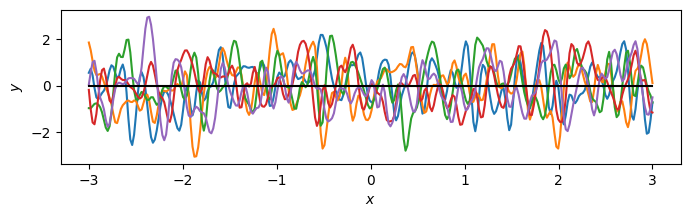

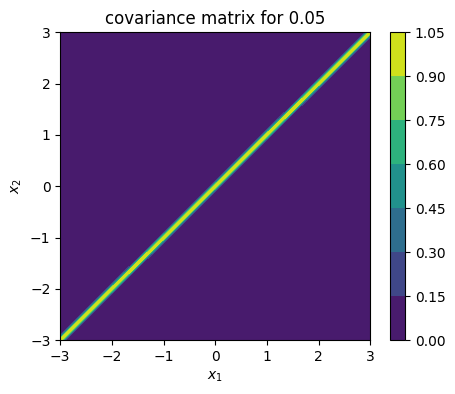

kernel_width = 0.3


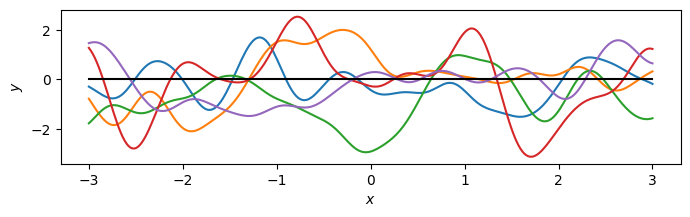

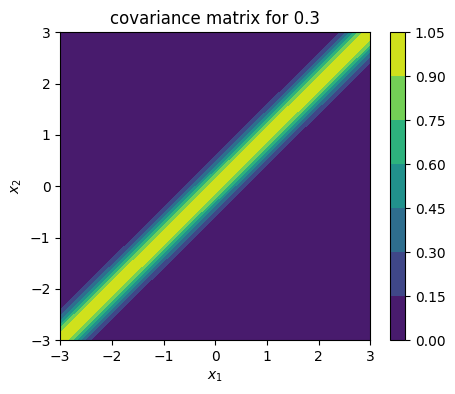

kernel_width = 1.0


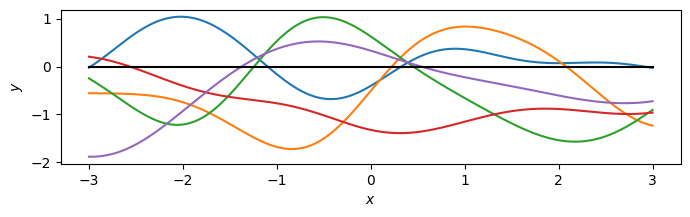

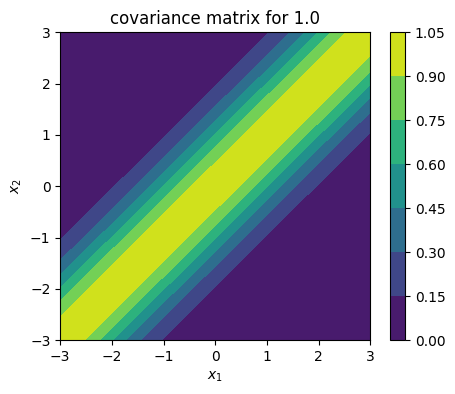

In [2]:
def kernel_RBF(x1, x2, kernel_width):
    #here x1 is a numpy array of different x values of shape (Nx1)
    #here x2 is a numpy array of different x values of shape (Nx2)
    x1_col = x1[:,None] #convert shape (Nx1) to (Nx1,1) #d)
    x2_row = x2[None,:] #convert shape (Nx2) to (1,Nx2) #d)
    diff_matrix = x1_col - x2_row # (Nx1,1) minus (1,Nx2) -> (Nx1, Nx2) #d)
    Kx1x2 = np.exp(-diff_matrix**2/(2*kernel_width**2)) # (Nx1, Nx2) #d=)
    return Kx1x2

def mean_zero_function(x):
    return np.zeros(x.shape[0])

kernel_widths = [0.05, 0.3, 1.0] #e=)

for kernel_width in kernel_widths:
    print(f'kernel_width = {kernel_width}')
    assert kernel_width>0
    xtest = np.linspace(-3,3,num=300)
    covariance_matrix = kernel_RBF(xtest, xtest, kernel_width=kernel_width) #e=)
    covariance_matrix = covariance_matrix + np.eye(len(xtest))*1e-10 #add small identity matrix to make it numerically well conditioned
    mean_array = mean_zero_function(xtest) #e=)

    plt.figure(figsize=(8,2))
    
    Ysamples = np.random.multivariate_normal(mean=mean_array, cov=covariance_matrix, size=5)
    for Ysample in Ysamples:
        plt.plot(xtest,Ysample)
    
    plt.plot(xtest,mean_array,'k',label='mean')
    plt.xlabel('$x$'); plt.ylabel('$y$')
    plt.show()
    plt.figure(figsize=(5,4))
    plt.title(f'covariance matrix for {kernel_width}')
    plt.contourf(xtest, xtest, covariance_matrix, origin='image')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.colorbar()
    plt.show()

Like we did before in **c)** we can update the prior disitribution based on the given measurements. 



$$
p\left (\left[\begin{array}{l}
Y_N \\
Y_*
\end{array}\right] \right ) = \mathcal{N}\left(\left[\begin{array}{l}
Y_N \\
Y_*
\end{array}\right] \mid \left[\begin{array}{l}
\mu(X_N) \\
\mu(X_*)
\end{array}\right],\left[\begin{array}{cc}
k(X_N, X_N) & k(X_N, X_*) \\
k(X_*, X_N) & k(X_*, X_*)
\end{array}\right]\right)$$



$$
p\left (\left[\begin{array}{l}
Y_N \\
Y_*
\end{array}\right] \right ) = \mathcal{N}\left(\left[\begin{array}{l}
Y_N \\
Y_*
\end{array}\right] \mid \left[\begin{array}{l}
\mu_X \\
\mu_*
\end{array}\right],\left[\begin{array}{cc}
K_{XX}& K_{X*} \\
K_{*X} & K_{**}
\end{array}\right]\right)$$

$$
p \left ( Y_* \mid Y_N \right ) = \mathcal{N}
\left (Y_* \mid \mu_*+K_{*X} K_{XX}^{-1} \left(Y_N - \mu_X \right), K_{**}- K_{*X} K_{XX}^{-1} K_{X*} \right )
$$

which uses the following well-known relation

$$
\left[\begin{array}{l}
\mathrm{v} \\
\mathrm{w}
\end{array}\right] \sim \mathcal{N}\left(\left[\begin{array}{l}
\mu_{\mathrm{v}} \\
\mu_{\mathrm{w}}
\end{array}\right],\left[\begin{array}{cc}
\Sigma_{\mathrm{vv}} & \Sigma_{\mathrm{vw}} \\
\Sigma_{\mathrm{vw}}^{\top} & \Sigma_{\mathrm{ww}}
\end{array}\right]\right)$$

$$p(\mathrm{w} \mid \mathrm{v})=\frac{p(\mathrm{v}, \mathrm{w})}{p(\mathrm{v})}=\mathcal{N}\left(\mathrm{w}|\mu_{\mathrm{w}}+\Sigma_{\mathrm{vw}}^{\top} \Sigma_{\mathrm{vv}}^{-1}\left(\mathrm{v}-\mu_{\mathrm{v}}\right), \Sigma_{\mathrm{ww}}-\Sigma_{\mathrm{vw}}^{\top} \Sigma_{\mathrm{vv}}^{-1} \Sigma_{\mathrm{vw}}\right)$$

With this, we are almost ready to implement our own Gaussian Process-based estimator. 

#### Important note on mean (co-)variance and output (co-)variance and the white kernel

Our outputs are often distrubed by noise processes. A very common manifestation of this phenomenon is white measurement noise, which can be defined as

$$Y_N =  f_0(X_N) + E_N$$
$$
p(E_N) = \mathcal{N}\left( E_N| 0, I_N \sigma_e^2 \right )
$$
which modifies the output covariance as

$$
\text{Cov}(Y_N, Y_N) = \text{Cov}(f_0(X_N), f_0(X_N)) + \text{Cov}(E_N, E_N)\\
 = \text{Cov}(f_0(X_N), f_0(X_N)) + I_N \sigma_e^2\\
$$
This additonal element introduced by the noise sometimes also called as a white kernel 
$$
k_w(x_j, x_i) = \sigma_e^2 \delta_{ij}
$$

where $\delta_{ij}=1$ if $i=j$ else $\delta_{ij} = 0$. This means that we can disntinguish two GPs. One for the function $f_0$ charactersied by $\text{Cov}(f_0(X_N), f_0(X_N))$ and one for the total oouput observation charactersied by $\text{Cov}(f_0(X_N), f_0(X_N)) + I_N \sigma_e^2$.

Thus, for a combined kernel definition, if we want to obtain the covariance matrix of the GP (for the function) instead of the GP for the output, then we need to write

$$
p\left (\left[\begin{array}{l}
Y_N \\
f_0(X_*)
\end{array}\right] \right ) = \mathcal{N}\left(\left[\begin{array}{l}
Y_N \\
f_0(X_*)
\end{array}\right] \mid \left[\begin{array}{l}
\mu_X \\
\mu_*
\end{array}\right],\left[\begin{array}{cc}
K_{XX}& K_{X*} \\
K_{*X} & K_{**} - I_* \sigma_e^2
\end{array}\right]\right)$$

$$
p \left ( f_0(X_*) \mid Y_N \right ) = \mathcal{N}
\left (f_0(X_*) \mid \mu_*+K_{*X} K_{XX}^{-1} \left(Y_N - \mu_X \right), K_{**} - K_{*X} K_{XX}^{-1} K_{X*}  - I_* \sigma_e^2 \right )
$$

Thus we need to subtract $I_* \sigma_e^2$ for the posterior covariance matrix to obtain the mean posterior covariance matrix.  


Alternatively, the white kernel can be separated from the main kernel defining the GP for the function as

$$
p\left (\left[\begin{array}{l}
Y_N \\
Y_*
\end{array}\right] \right ) = \mathcal{N}\left(\left[\begin{array}{l}
Y_N \\
Y_*
\end{array}\right] \mid \left[\begin{array}{l}
\mu_X \\
\mu_*
\end{array}\right],\left[\begin{array}{cc}
K_{XX}+ I_N \sigma_e^2& K_{X*} \\
K_{*X} & K_{**} + I_* \sigma_e^2
\end{array}\right]\right)$$



$$
p\left (\left[\begin{array}{l}
Y_N \\
f_0(X_*)
\end{array}\right] \right ) = \mathcal{N}\left(\left[\begin{array}{l}
Y_N \\
f_0(X_*)
\end{array}\right] \mid \left[\begin{array}{l}
\mu_X \\
\mu_*
\end{array}\right],\left[\begin{array}{cc}
K_{XX}+ I_* \sigma_e^2& K_{X*} \\
K_{*X} & K_{**} 
\end{array}\right]\right)$$

which is the commonly used form for GP-based estimators in practice.

**g)** Below you can find a GP estimator based on the equations given above. Finish up this estimator by computing the posteriori mean and covariance. Furthermore, compute the standard deviation of the measurement $Y_*$ and the standard deviation of the mean $f_0(X_*)$ using the posterior covariance matrix. 

*Tip: use `np.linalg.inv` to compute the inverse, `np.diag` to extract the diagonal, `np.eye` to create an identity matrix.*

*Tip: the standard deviation is the square root of the variance*

*Note: a nummericaly efficient implementation can be achived by Cholesky factorization instead of really computing the inverse* 

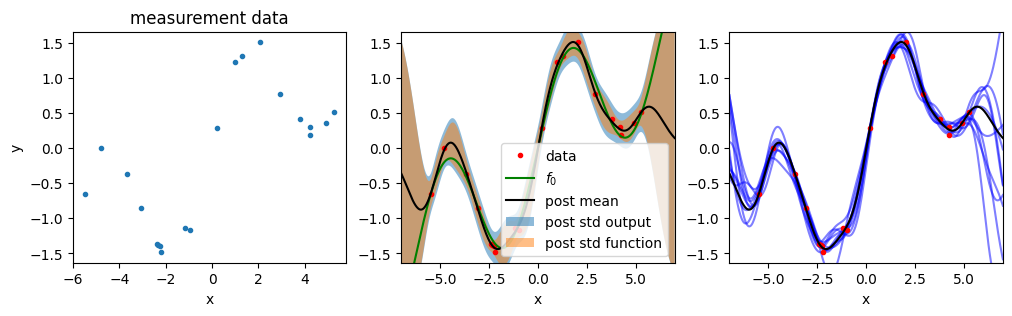

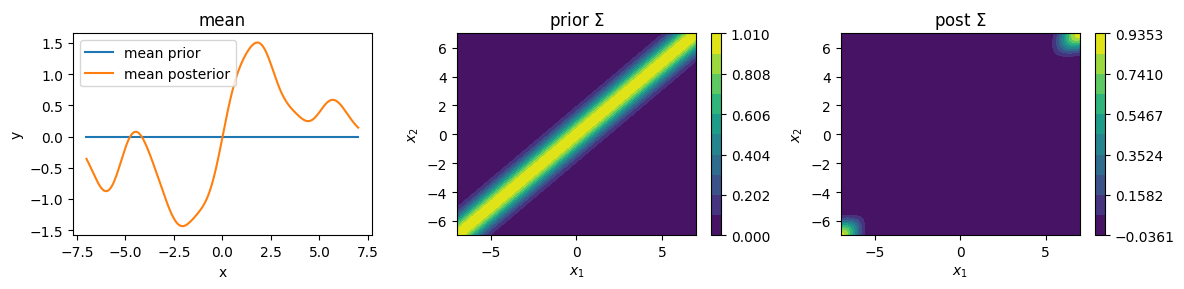

In [3]:
def kernel_RBF(x1, x2, kernel_width):
    x1_col = x1[:,None] #convert shape (Nx1) to (Nx1,1)
    x2_row = x2[None,:] #convert shape (Nx2) to (1,Nx2)
    diff_matrix = x1_col - x2_row # (Nx1,1) minus (1,Nx2) -> (Nx1, Nx2)
    return np.exp(-diff_matrix**2/(2*kernel_width**2)) #return (Nx1, Nx2)

def kernel_white(x1, x2, noise_level):
    assert len(x1)==len(x2)
    return np.eye(len(x1))*noise_level**2

def kernel(x1, x2, kernel_width, noise_level, add_noise=True):
    if add_noise:
        return kernel_RBF(x1, x2, kernel_width) + kernel_white(x1, x2, noise_level)
    else:
        return kernel_RBF(x1, x2, kernel_width)

def mean_zero_function(x):
    return np.zeros(x.shape[0])


## Generate data ##
np.random.seed(23)
N = 20
xlim = 7
measure_noise_std = 0.1
X_N = np.random.uniform(-5.5,5.5, size=N)
f0 = lambda x: x/4 + np.sin(x)
Y_N = f0(X_N) + np.random.normal(scale=measure_noise_std, size=N)
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.title('measurement data')
plt.ylabel('y')
plt.xlabel('x')
plt.plot(X_N, Y_N,'.')
ylims = plt.ylim()

#S = * in the script
kernel_width = 0.9
noise_level = measure_noise_std

X_S = np.linspace(-xlim,xlim, 400) #X_*
K_XX = kernel(X_N, X_N, kernel_width, noise_level, add_noise=True)  #K_XX
K_SX = kernel(X_S, X_N, kernel_width, noise_level, add_noise=False) #K_*X
K_XS = kernel(X_N, X_S, kernel_width, noise_level, add_noise=False) #K_*X
K_SS = kernel(X_S, X_S, kernel_width, noise_level, add_noise=True) #K_*X
mu_X = mean_zero_function(X_N)
mu_S = mean_zero_function(X_S)

K_XX_inv = np.linalg.inv(K_XX) #g=)

mu_post = mu_S + K_SX@K_XX_inv@(Y_N - mu_X) #g=)
K_post  = K_SS - K_SX@K_XX_inv@K_XS #g=)

K_post_noiseless  = K_post - np.eye(len(X_S))*noise_level**2 #g=)

#compute standard deviations:
std_post = np.diag(K_post)**0.5 #g=)
std_mean_post = np.diag(K_post_noiseless)**0.5  #g=)

#plot data
plt.subplot(1,3,2)
plt.xlabel('x')
plt.plot(X_N, Y_N,'.r',label='data')
plt.plot(X_S, f0(X_S),'g',label='$f_0$')
plt.plot(X_S, mu_post,'k',label='post mean')
plt.fill_between(X_S, mu_post-2*std_post,y2=mu_post+2*std_post,alpha=0.5,label='post std output')
plt.fill_between(X_S, mu_post-2*std_mean_post,y2=mu_post+2*std_mean_post,alpha=0.5,label='post std function')
plt.legend()
plt.ylim(ylims)
plt.xlim(-xlim,xlim)
# plt.show()

plt.subplot(1,3,3)
plt.xlabel('x')
Y_S_samples = np.random.multivariate_normal(mu_post, K_post_noiseless + np.eye(len(X_S))*1e-10, size=10)
plt.plot(X_S, Y_S_samples.T,'b',alpha=0.5)
plt.plot(X_N, Y_N,'.r')
plt.plot(X_S, mu_post,'k')
# plt.fill_between(X_S, mu_post-np.diag(K_post)**0.5,y2=mu_post+np.diag(K_post)**0.5,alpha=0.5)
plt.ylim(ylims)
plt.xlim(-xlim,xlim)
plt.show()

plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.ylabel('y')
plt.xlabel('x')
plt.title('mean')
plt.plot(X_S, mu_S,label='mean prior')
plt.plot(X_S, mu_post,label='mean posterior')
plt.legend()

to_img = lambda x: plt.contourf(X_S, X_S, x, origin='image', levels=np.linspace(np.min(x), np.max(x), 11))

plt.subplot(1,3,2)
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
plt.title('prior $\\Sigma$')
to_img(K_SS)
plt.colorbar()
plt.subplot(1,3,3)
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
plt.title('post $\\Sigma$')
to_img(K_post)
plt.colorbar()
plt.tight_layout()
plt.show()


### Theory note: A GP for functions

The concept we discussed, can be extended to a probability distribution over all possible functions. like:
$$
p(f) = \mathcal{N}(\mu(\cdot), k(\cdot, \cdot))
$$
This process can define a distribution of functions which can be updated with measurements like before. 

$$
p\left (\left[\begin{array}{l}
Y_N \\
f
\end{array}\right] \right ) = \mathcal{N}\left(\left[\begin{array}{l}
Y_N \\
f
\end{array}\right] \mid \left[\begin{array}{l}
\mu_X \\
\mu(\cdot)
\end{array}\right],\left[\begin{array}{cc}
K_{XX}& k(X, \cdot) \\
k(\cdot, X) & k(\cdot, \cdot)
\end{array}\right]\right)$$



$$
p \left ( f \mid Y_N \right ) = \mathcal{N}
\left (f \mid \mu(\cdot)+k(\cdot, X) K_{XX}^{-1} \left(Y_N - \mu(\cdot) \right), k(\cdot, \cdot)- k(\cdot, X) K_{XX}^{-1} k(X, \cdot) \right )
$$

Hence, a Gaussian process takes a prior distribution of functions $p(f)$ and is able to update it with data to obtain a posterior distribution of functions $p(f|Y_N)$.

###  Theory note: Relationship of GPs and Reproducing Kernel Hilbert Spaces

GP is a specific version of a Reproducing Kernel Hilbert Spaces and the connected estimators which can model a vast range of (almost all) functions.



### (optional) Exercise 1.3: How to define a GP if there is more than a single input?

This is relatively simple since we can write the kernel for vectors as, for instance with an RBF kernel;

$$
k(x_i, x_j) = \exp\left ( - \frac{\| x_i - x_j\|_2^2}{2 \sigma_l} \right )
$$

**h)** Implement the RBF kernel below for inputs which are vectors. Afterwards run the cell and observe the results for different kernel widths.

/tmp/ipykernel_18/3191364573.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')


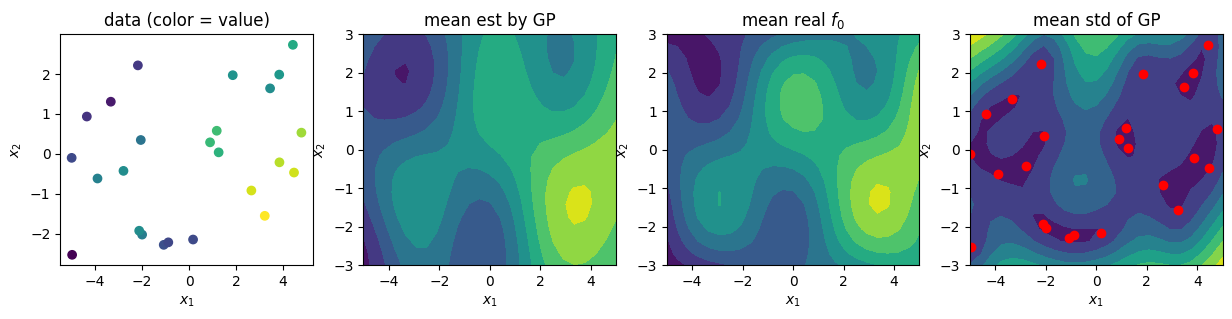

In [4]:
def kernel_RBF(x1, x2, kernel_width):
    #x1 has shape (Nx1, nx)
    #x2 has shape (Nx2, nx)
    
    x1_col = x1[:,None] #convert shape (Nx1, nx) to (Nx1,1, nx) #h)
    x2_row = x2[None,:] #convert shape (Nx2, nx) to (1,Nx2, nx) #h)
    diff_matrix = x1_col - x2_row # (Nx1,1,nx) minus (1,Nx2,nx) -> (Nx1, Nx2,nx) #h)
    return np.exp(-np.sum(diff_matrix**2,axis=2)/(2*kernel_width**2)) #return (Nx1, Nx2, nx) #h)

def kernel_white(x1, x2, noise_level):
    assert len(x1)==len(x2)
    return np.eye(len(x1))*noise_level**2

def kernel(x1, x2, kernel_width, noise_level, add_noise=True):
    if add_noise:
        return kernel_RBF(x1, x2, kernel_width) + kernel_white(x1, x2, noise_level)
    else:
        return kernel_RBF(x1, x2, kernel_width)

def mean_zero_function(x):
    return np.zeros(x.shape[0])

np.random.seed(23)
N = 25
X0_N = np.random.uniform(-5.,5., size=N)
X1_N = np.random.uniform(-3.,3., size=N)
X_N = np.array([X0_N, X1_N]).T

measure_noise_std = 0.1

f0 = lambda x: x[:,0]/4 + np.sin(x[:,1])*np.cos(x[:,0]) - (x[:,1]/3)**2
Y_N = f0(X_N) + np.random.normal(scale=measure_noise_std, size=N)

from matplotlib.cm import get_cmap
cmap = get_cmap('viridis')
plt.figure(figsize=(15,3))
c = cmap((Y_N-np.min(Y_N))/(np.max(Y_N) - np.min(Y_N)))
plt.subplot(1,4,1)
plt.title('data (color = value)')
plt.scatter(X0_N, X1_N, c=c)
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')

X0_S = np.linspace(-5, 5, 25)
X1_S = np.linspace(-3, 3, 20)
X_S = np.stack(np.meshgrid(X0_S, X1_S), axis=-1).reshape(-1, 2)
Y_S = f0(X_S)

kernel_width = 1.85 

noise_level = measure_noise_std

K_XX = kernel(X_N, X_N, kernel_width, noise_level, add_noise=True)

K_SX = kernel(X_S, X_N, kernel_width, noise_level, add_noise=False)
K_XS = kernel(X_N, X_S, kernel_width, noise_level, add_noise=False)
K_SS = kernel(X_S, X_S, kernel_width, noise_level, add_noise=True)
mu_X = mean_zero_function(X_N)
mu_S = mean_zero_function(X_S)

K_XX_inv = np.linalg.inv(K_XX) 

K_post  = K_SS - K_SX@K_XX_inv@K_XS 
mu_post = mu_S + K_SX@K_XX_inv@(Y_N - mu_X) 

K_post_noiseless  = K_post - np.eye(len(X_S))*noise_level**2 

std_post = np.diag(K_post)**0.5
std_mean_post = np.diag(K_post_noiseless)**0.5

plt.subplot(1,4,2)
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
plt.title('mean est by GP')
l = plt.contourf(X0_S, X1_S, mu_post.reshape(X1_S.shape[0], X0_S.shape[0]))
plt.subplot(1,4,3)
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
plt.title('mean real $f_0$')
plt.contourf(X0_S, X1_S, Y_S.reshape(X1_S.shape[0], X0_S.shape[0]), levels=l.levels)

plt.subplot(1,4,4)
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
plt.title('mean std of GP')
plt.contourf(X0_S, X1_S, std_mean_post.reshape(X1_S.shape[0], X0_S.shape[0]))
plt.scatter(X0_N, X1_N,c='r')
plt.show()

## Exercise 2: Choosing a good prior distribution (i.e. kernel hyperparameter optimization)

With this exercise, we would like to address the issue of choosing good kernel hyperparameters. 

But fist, finish the implementation of the new GP posterior estimator.

**a)** Finish `get_GP_post` which should return the mean function and the covarience function describing the posteriori predictive distirbution.

In [5]:
import numpy as np
from matplotlib import pyplot as plt

def get_GP_post(kernel, sigma_e, X_N, Y_N, mean_function=None):
    # kernel is a function like kernel([x1,x2,x3],[x1,x2,x3]) (without the white noise kernel)
    # sigma_e is the noise amplitude
    # X_N are the input points
    
    #evaluate kernel with white noise kernel
    K_XX = kernel(X_N, X_N) + np.eye(X_N.shape[0])*sigma_e**2 #a=) 
    K_XX_inv = np.linalg.inv(K_XX) #a=)
    if mean_function is None:
        mu_X = np.zeros((X_N.shape[0],))
    else:
        mu_X = mean_function(X_N) #a=)

    
    #this function of the posterior will be returned and K_XX, K_XX_inv, mu_X can be used in function.
    #context: https://www.geeksforgeeks.org/returning-a-function-from-a-function-python/
    def evaluate_post(X_S, mean=False):
        N_S = X_S.shape[0]
        K_SX = kernel(X_S, X_N) #a=)
        K_XS = K_SX.T  #a=)
        if mean==False:
            K_SS = kernel(X_S, X_S) + np.eye(X_S.shape[0])*sigma_e**2 #a=)
        else:
            K_SS = kernel(X_S, X_S) #a=)

        if mean_function==None:
            mu_S = np.zeros((X_S.shape[0],))
        else:
            mu_S = mean_function(X_S) #a=)

        mu_post = mu_S + K_SX@K_XX_inv@(Y_N - mu_X) #a=)
        K_post  = K_SS - K_SX@K_XX_inv@K_XS #a=)

        return mu_post, K_post
    
    return evaluate_post

def RBF_kernel(x1, x2, kernel_width):
    diff = x1[:,None] - x2[None,:]
    Kxx = np.exp(-diff**2/(2*kernel_width**2))
    return Kxx


**b)** Read the data from `lownoise.mat` by placing it in the same folder as the notebook to obtain `X_N` and `Y_N`. We will estimate multiple GP on this data using different kernel parameters. This will be visualized in the `plot` function. Your task is to finish up the GP posterior estimation inside `plot` evaluated on a set of points `xvisualize`. This should also produce the mean, std, and std of the mean of the posterior for `xvisualize` such that it can be used in the visualization.
Afterwards, run the cell and observe the dependence of the resutls on the chosen $\sigma_e$ (assumed noise varaince) and the kernel width (assumed smoothness of the function). Explain this dependence on the hyper parameters and give a rough estimate of both $\sigma_e$ and the kernel width!

**Answer b):** Like before kernel width promotes smoothness of the function, a rough estimate would be around 0.5 since the function is approximately constant in regions of length 0.5. Secondly, $\sigma_e$ corresponds to the allowed divitation of mean w.r.t. the measurment data, which based on a rough estimate of the noise amplitude in the data could be 0.05 for the `low` case. 

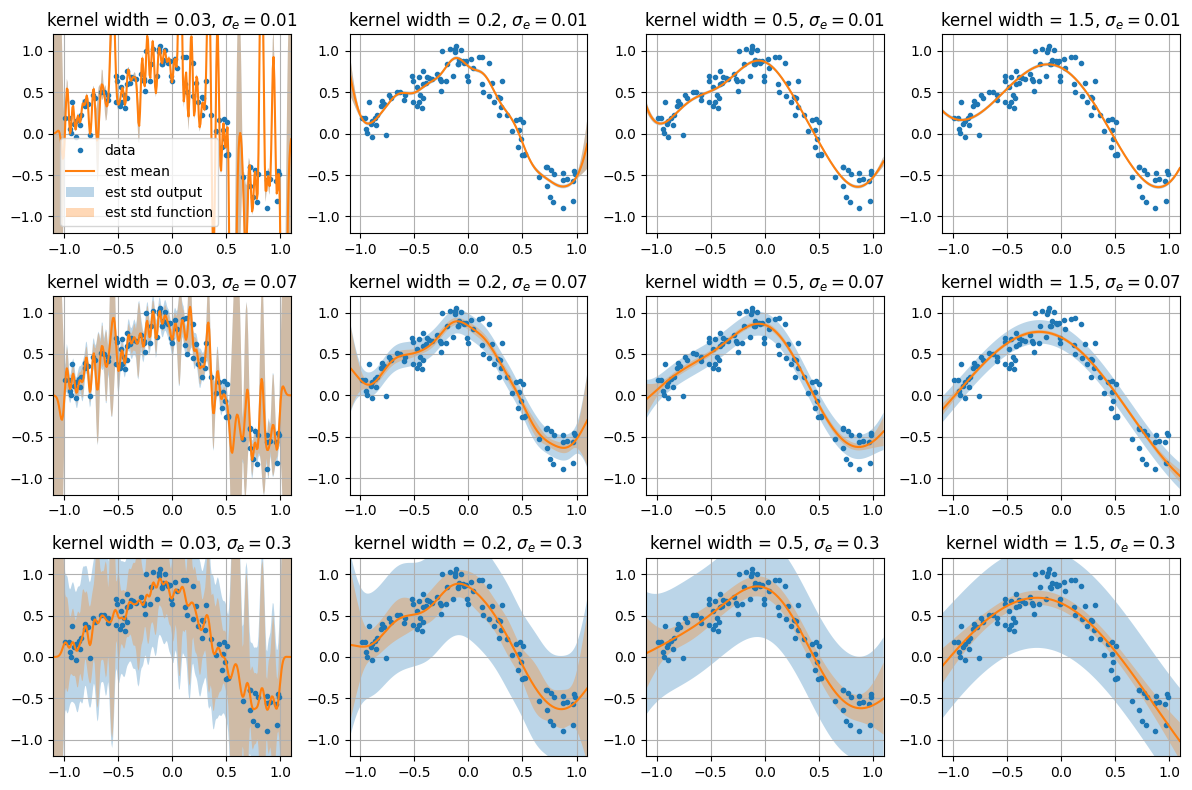

In [6]:
from scipy.io import loadmat
import numpy as np

######### selecting dataset 'low', 'med' or 'high'  #########
ident = 'high'

#load data
out = loadmat(f'/kaggle/input/l4-5-gaussian-processes-dataset/{ident}noise.mat') #train data
X_N = out['x'][:,0] #shape=(N,)
Y_N = out['y'][:,0] #shape=(N,)
out = loadmat(f'/kaggle/input/l4-5-gaussian-processes-dataset/valid_{ident}noise.mat') #validation data
xtest = out['x'][:,0] #shape=(Ntest,)
ytest = out['y'][:,0] #shape=(Ntest,)

xvisualize = np.linspace(-1.1,1.1,num=300) #xpoints for visualization


def plot(X_N, Y_N, xvisualize, sigma_e = 0.1, kernel_width = 0.1):
    
    kernel = lambda x1, x2: RBF_kernel(x1, x2, kernel_width=kernel_width)
    
    #use get_GP_post:
    GP_post = get_GP_post(kernel=kernel, sigma_e=sigma_e, X_N=X_N, Y_N=Y_N) #b=)

    mu_visualize, K_visualize = GP_post(xvisualize) #b=)
    std_visualize = np.diag(K_visualize)**0.5 #b=)
    _, K_visualize_mean = GP_post(xvisualize, mean=True) #b=)
    std_mean_visualize = np.diag(K_visualize_mean)**0.5 #b=)

    plt.title(f'kernel width = {kernel_width}, $\\sigma_e = {sigma_e}$ ')
    plt.plot(X_N,Y_N,'.',label='data')
    plt.plot(xvisualize,mu_visualize,label='est mean')
    plt.fill_between(xvisualize,\
                     mu_visualize-2*std_visualize,\
                     mu_visualize+2*std_visualize,alpha=0.3,label='est std output')
    plt.fill_between(xvisualize,\
                     mu_visualize-2*std_mean_visualize,\
                     mu_visualize+2*std_mean_visualize,alpha=0.3,label='est std function')
    plt.tight_layout()
    plt.grid()
    plt.xlim(min(xvisualize), max(xvisualize))
    plt.ylim(-1.2, 1.2)


plt.figure(figsize=(12,8))
i = 0
for sigma_e in [0.01, 0.07, 0.3 ]:
    for kernel_width in [0.03,0.2,0.5,1.5]:
        i+=1
        plt.subplot(3,4,i)
        plot(X_N, Y_N, xvisualize, sigma_e, kernel_width)
        if i==1:
            plt.legend()
plt.show()

Having a rough estimate of the hyperparameters can be done for simple cases, but can be very difficult for a real-world problems. In the next questions, we will start exploring methods to automatically choose the hyperparameters. 

**c)** Split `X_N` and `Y_N` into a dedicated training of 80% and validation set of 20%. Afterwards, finish the implementation of the `RMS` function which estimates a GP posterior using `X_N_train`, `Y_N_train` and evaluates RMS on the validation data.

*tip: RMS is given by $\sqrt{\frac{1}{N} \sum (\mu_i - y_i)^2}$*

**d)** Run the cell below and observe the RMS landscape as a function of both parameters. It also visualizes the GP posterior of hyperparameters with the lowest RMS within this landscape. Do these hyperparameters seem realistic? And why is this the case when using the RMS validation method?

**answer d):** The kernel width is quite realistic but $\sigma_e$ is way too low. The error in $\sigma_e$ is present since the RMS measure only considers the mean of the function which $\sigma_e$ does not change significantly. 


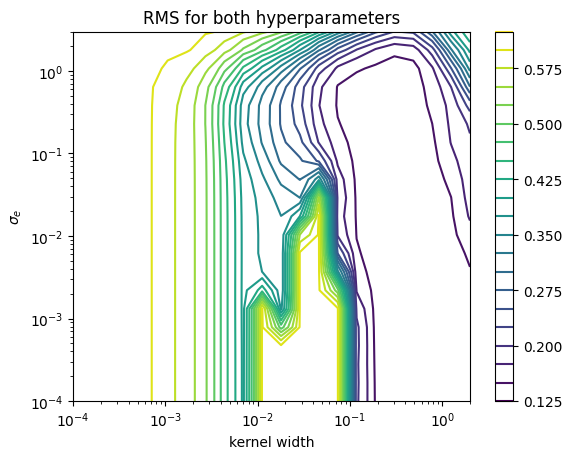

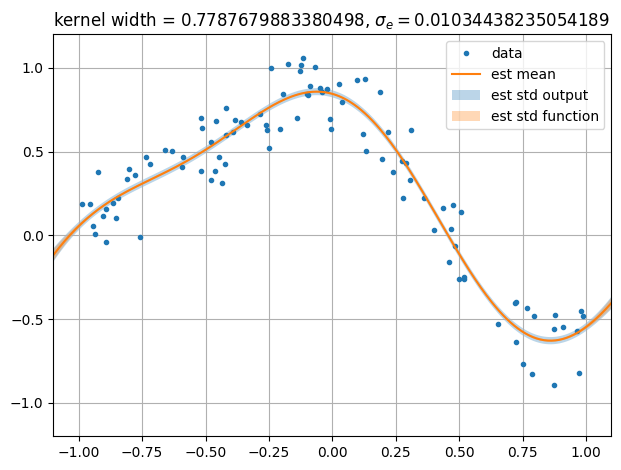

In [7]:
val_frac = 0.2
Ntrain = int(X_N.shape[0]*(1-val_frac))

X_N_train, X_N_val = X_N[:Ntrain], X_N[Ntrain:] #c=)
Y_N_train, Y_N_val = Y_N[:Ntrain], Y_N[Ntrain:] #c=)


def RMS(X_N_train, Y_N_train, X_N_val, Y_N_val, sigma_e, kernel_width):
    
    kernel = lambda x1, x2: RBF_kernel(x1, x2, kernel_width=kernel_width)
    GP_post = get_GP_post(kernel=kernel, sigma_e=sigma_e, X_N=X_N_train, Y_N=Y_N_train) #c=)
    
    mu_val, K_val = GP_post(X_N_val) #c=)
    return np.mean((mu_val - Y_N_val)**2)**0.5 #c)

sigma_e_list = np.geomspace(0.0001,3,num=21) #increasing value in log space
kernel_width_list = np.geomspace(0.0001,2,num=22) #increasing value in log space

mat_out = []
for sigma_e in sigma_e_list:
    mat_out_row = []
    for kernel_width in kernel_width_list:
        mat_out_row.append(RMS(X_N_train, Y_N_train, X_N_val, Y_N_val, sigma_e, kernel_width))
    mat_out.append(mat_out_row)
RMS_mat = np.array(mat_out)

#plotting for d)
plt.contour(kernel_width_list, sigma_e_list, np.clip(RMS_mat,-float('inf'),np.percentile(RMS_mat.flat,70)), levels=20)
plt.loglog()
plt.colorbar()
plt.xlabel(r'kernel width')
plt.ylabel(r'$\sigma_e$')
plt.title("RMS for both hyperparameters")
plt.show()


best1, best2 = np.unravel_index(np.argmin(RMS_mat),RMS_mat.shape)
plot(X_N, Y_N, xvisualize, sigma_e_list[best1],kernel_width_list[best2])
plt.legend()
plt.show()


An alternative method is to minimise the marginal negative loglikelihood. This is possible since we can shape the prior distribution using kernel and mean parameters given by $\eta$  as you saw it in Exercise 1.2. We should shape this prior such that it maximizes the probability $Y_N$ given $X_N$ is sampled from the prior distribution. In other words


$$
\max_\eta P(Y_N) = \max_\eta \mathcal{N} ( Y_N| \mu_\eta(X_N), k_\eta(X_N, X_N)) \\
\min_\eta - \log  P(Y_N) = \min_\eta - \log \mathcal{N} ( Y_N| \mu_X, K_{XX}) \\
 =  \min_\eta  - \log \left ( (2 \pi)^{-\frac{N}{2}} \det ( K_{XX})^{-\frac{1}{2}} \exp \left (-\frac{1}{2} (y-\mu_X)^\top K_{XX}^{-1} (y-\mu_X) \right) \right )\\
$$

**e)** Finish the derivation by separating the log likelihood to a sum. 

**Answer e):** $$\min_\eta \frac{N}{2} \log (2 \pi)  + \frac{1}{2} \log ( \det ( K_{XX})) + \frac{1}{2} (y-\mu_X)^\top K_{XX}^{-1} (y-\mu_X)$$

**f)** Do the same analysis as you did with the RMS validation set method but for minimization of the marginal negative loglikelihood. To do this analysis:
 1. finish `eval_GP_prior` which returns $\mu_X$ and $K_{XX}$ for the given kernel and mean function, 
 2. finish `meannegloglikelihood` which computes the mean (divided by `N`) negative log-likelihood given a mean and covariance matrix, 
 3. evaluate this method of picking the prior using the visualizations. 

**Answer f):** The data is almost compactly encapsulated by the 2 x standard deviation bound (95%). Furthermore, we do not need a validation set for this approach which makes the method more elegant and cheaper in practice (all data can be used for estimation). However, this implementation can be computationally quite intensive since it needs to compute $K_{XX}^{-1}$. 

*Tip: use [slogdet](https://numpy.org/doc/stable/reference/generated/numpy.linalg.slogdet.html) to compute the log determinant efficiently*.

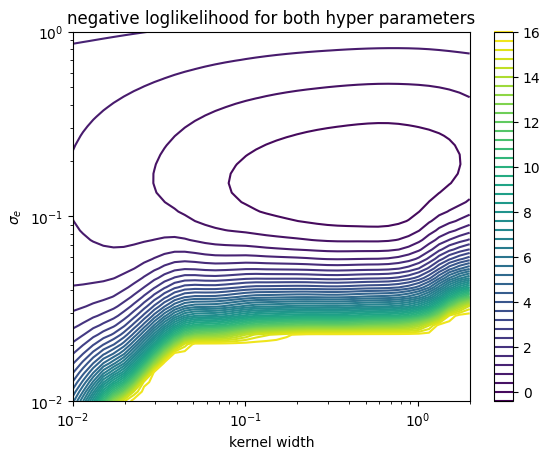

best kernel parameters: 0.5888749408017715 0.15117750706156624
min value: -0.36167137604399247


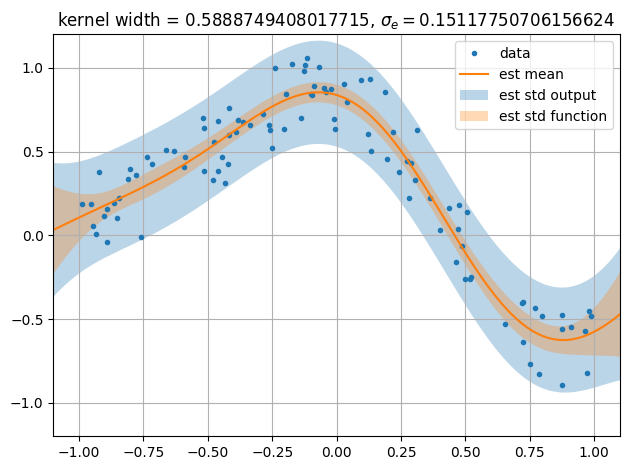

In [8]:
def eval_GP_prior(kernel, sigma_e, X_N, mean_function=None, mean = False):
    # kernel is a function like kernel([x1,x2,x3],[x1,x2,x3]) (without the white noise kernel)
    # sigma_e is the noise amplitude
    # X_N are the input points
    # mean_function is the mean function
    # mean: bool which is true if the white noise kernel should not be applied.
    
    #returns the mean vector and the covariance matrix of the prior evaluated in X_N
    if mean:
        K_XX = kernel(X_N, X_N) #e=)
    else:
        K_XX = kernel(X_N, X_N) + np.eye(X_N.shape[0])*sigma_e**2  #e=)
    if mean_function==None:
        mu_X = np.zeros((X_N.shape[0],))
    else:
        mu_X = mean_function(X_N) #e=)
    return mu_X, K_XX

def meannegloglikelihood(Y_N, mu, K): #K of the standard deviation
    N = len(Y_N)
    norm_term =  N/2*np.log(2*np.pi) #e=)
    complexity_term = 0.5*np.linalg.slogdet(K)[1] #e=)
    data_term = 0.5*(Y_N-mu)@np.linalg.inv(K)@(Y_N-mu) #e=)

    loglikelihood = -(norm_term + data_term + complexity_term)
    return -loglikelihood/N

def compute_meannegloglikelihood(X_N, Y_N, sigma_e, kernel_width):
    kernel = lambda x1, x2: RBF_kernel(x1, x2, kernel_width=kernel_width)
    mu_N, Kxx_N = eval_GP_prior(kernel=kernel, sigma_e=sigma_e, X_N=X_N) #no input!! this is the prior
    return meannegloglikelihood(Y_N, mu_N, Kxx_N)
    
sigma_e_list = np.geomspace(0.01,1,num=40) #increasing value in log space
kernel_width_list = np.geomspace(0.01,2,num=40) #increasing value in log space

mat_out_like = [] 
for sigma_e in sigma_e_list:
    mat_out_row = [] 
    for kernel_width in kernel_width_list: 
        mat_out_row.append(compute_meannegloglikelihood(X_N, Y_N, sigma_e, kernel_width))
    mat_out_like.append(mat_out_row)
mat_out_like = np.array(mat_out_like)

#plotting for e)
plt.contour(kernel_width_list, sigma_e_list, np.clip(mat_out_like,\
                                                     np.percentile(mat_out_like.flat,0),\
                                                     np.percentile(mat_out_like.flat,85)), levels=40)
plt.colorbar()
plt.xlabel(r'kernel width')
plt.ylabel(r'$\sigma_e$')
plt.title("negative loglikelihood for both hyper parameters")
plt.loglog()
plt.show()

best1, best2 = np.unravel_index(np.argmin(mat_out_like),mat_out_like.shape)
print('best kernel parameters:',kernel_width_list[best2], sigma_e_list[best1])
print('min value:', np.min(mat_out_like))
plot(X_N, Y_N, xvisualize, sigma_e_list[best1],kernel_width_list[best2])
plt.legend()
plt.show()


**g)** use `minimize` from `scipy.optimize` to find the maximum log likelihood.

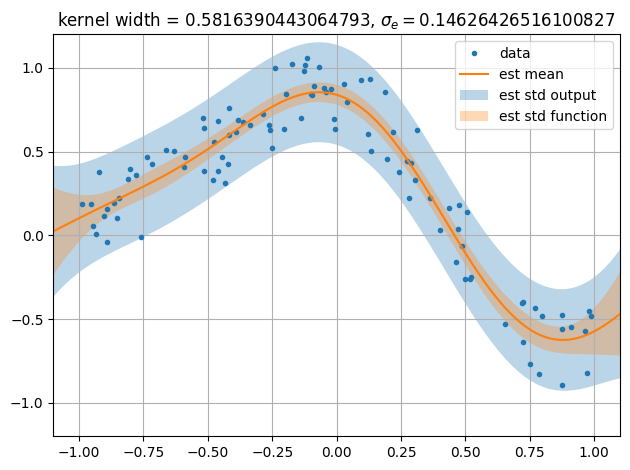

best sigma_e 0.146
best kernel width 0.582


In [9]:
from scipy.optimize import minimize
#fun(x, *args) -> float (see docs)

# maximize marginal log likelihood
optimize_fun = lambda th: compute_meannegloglikelihood(X_N, Y_N, th[0], th[1])
x0 = [sigma_e_list[best1],kernel_width_list[best2]] 
fsol = minimize(optimize_fun, x0, bounds=[[1e-5,4],[1e-4,10]]) #g=)

sigma_e_best, kernel_width_best = fsol.x
plot(X_N, Y_N, xvisualize, sigma_e_best, kernel_width_best)
plt.legend()
plt.show()

print(f'best sigma_e {sigma_e_best:.3f}')
print(f'best kernel width {kernel_width_best:.3f}')

**h)** re-run this exercise with 'med' and 'high' noise datasets (see *a)*). How does the optimal kernel width and $\sigma_e$ change with the choice of dataset and why?

**Answer h):** low: kernel width is 0.64, $\sigma_e = 0.029$, med:  kernel width is 0.64, $\sigma_e = 0.058$, high: kernel width is 0.58, $\sigma_e = 0.146$. Hence, as the noise grows $\sigma_e$ changes accordingly with the white noise interpretation whereas the kernel width is mostly unchanged since the underlying function is unchanged. 

## Exercise 3: Using sklearn GP

Now that you understand the basics of Gaussian processes let's switch to a nicely implemented version included in sklearn [1.7 Gaussian Processes](https://scikit-learn.org/stable/modules/gaussian_process.html). It includes features like:

* The hyperparameters of the kernel are optimized during the fitting of `GaussianProcessRegressor` by maximizing the log-marginal-likelihood (LML) (and using `scipy.optimize.minimize`). 
* Different kernels can be specified. Common kernels are provided, but it is also possible to specify custom kernels.

Sklearn assumes that one uses a zero mean function. In case the mean function is fixed, this is not limiting since one can re-write 

$$
p\left (\left[\begin{array}{l}
Y_N \\
Y_*
\end{array}\right] \right ) = \mathcal{N}\left(\left[\begin{array}{l}
Y_N \\
Y_*
\end{array}\right] \mid \left[\begin{array}{l}
\mu(X_N) \\
\mu(X_*)
\end{array}\right],\left[\begin{array}{cc}
k(X_N, X_N) & k(X_N, X_*) \\
k(X_*, X_N) & k(X_*, X_*)
\end{array}\right]\right)$$

$$
p\left (\left[\begin{array}{l}
Y_N - \mu(X_N) \\
Y_* - \mu(X_*)
\end{array}\right] \right ) = \mathcal{N}\left(\left[\begin{array}{l}
Y_N \\
Y_*
\end{array}\right] \mid \left[\begin{array}{l}
0 \\
0
\end{array}\right],\left[\begin{array}{cc}
k(X_N, X_N) & k(X_N, X_*) \\
k(X_*, X_N) & k(X_*, X_*)
\end{array}\right]\right)$$

Thus it is equivalent to substracting the mean from the output data and adding the mean back to the prediction of the GP. However, if one wishes to parametrize the mean tune its hyper-parmaters together with the kernel then a custom made implementation is required.

**a)** Construct a kernel as a combination of a Radial Basis Function `RBF` and a `WhiteKenel` using `+` and estimate a model using the x and y data generated below. Show the resulting model with `.predict` (set `return_std=True`).

*Tip: read the documentation of Gaussian processes provided here [function doc](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html), [User guide](https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process). Note that the width of the kernel is called scale length in this implementation.* 

*Tip: set `n_restarts_optimizer=10` for more robust hyperparamter optimization*

*Note: sklearn uses multi-variate inputs so the x arrays need to have the shape of `(Nsamp, Nfeatures)` with `Nfeatures=1`*

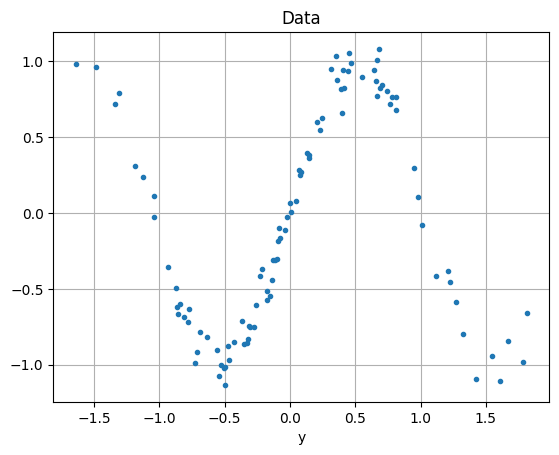

Resulting kernel hyperparameters: RBF(length_scale=0.626) + WhiteKernel(noise_level=0.00891)


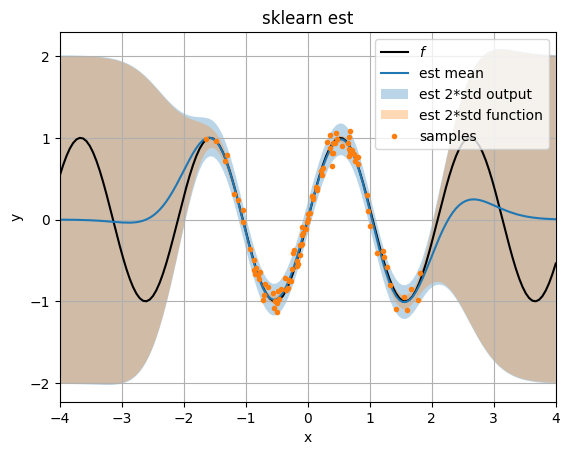

In [10]:
# f0 = lambda x: np.sin(3*x) + 0.5*np.random.normal(loc=0,scale=0.9,size=x.shape)
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(43)
N = 100
noise = 0.1
f0 = lambda x: np.sin(3*x)

x = np.random.normal(loc=0,scale=0.8,size=N)
y = f0(x) + noise*np.random.normal(loc=0,scale=0.9,size=x.shape)
xtest = np.linspace(-4,4,num=150)
ytest = f0(xtest)

plt.plot(x,y,'.')
plt.grid(); plt.xlabel('x'); plt.xlabel('y'); plt.title('Data')
plt.show()


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared


#construct kernel and initial hyper-parameters
ker = RBF(length_scale=1) + WhiteKernel(noise_level=1.0) #a=)
#construct regressor
reg = GaussianProcessRegressor(ker,n_restarts_optimizer=10) #a=)
#fit regressor and optimize hyperparameters using MAP
reg.fit(x[:,None],y) 

print('Resulting kernel hyperparameters:',reg.kernel_) #print optimized kernel
sigma_e = np.exp(reg.kernel_.k2.theta)**0.5 #extract the noise
#use regressor
ytest_p, ytest_std = reg.predict(xtest[:,None],return_std=True) #a=)
ytest_std_mean = (ytest_std**2 - sigma_e**2)**0.5 #remove sigma_e noise to get mean deviation

#plot result
plt.plot(xtest,ytest,'k',label='$f$')
plt.plot(xtest,ytest_p,label='est mean')
plt.xlim(min(xtest),max(xtest))
plt.fill_between(xtest,ytest_p-2*ytest_std,ytest_p+2*ytest_std,alpha=0.3,label='est 2*std output')
plt.fill_between(xtest,ytest_p-2*ytest_std_mean,ytest_p+2*ytest_std_mean,alpha=0.3,label='est 2*std function')
plt.plot(x,y,'.',label='samples')
plt.grid(); plt.legend(); plt.xlabel('x'); plt.ylabel('y'); plt.title('sklearn est')
plt.show()


Gaussian processes are probabilistic in nature, hence we can sample them. 

**c)** Sample 7 times the obtained Gaussian process on `xtest` using the mean and covariance matrix by calling `reg.predict(...,return_cov=True)`. Then, sample it using `np.random.multivariate_normal` and interpret the results.

Alteratively these two operations are implemented by `ysamps = reg.sample_y(xtest[:,None],n_samples=7)`. 

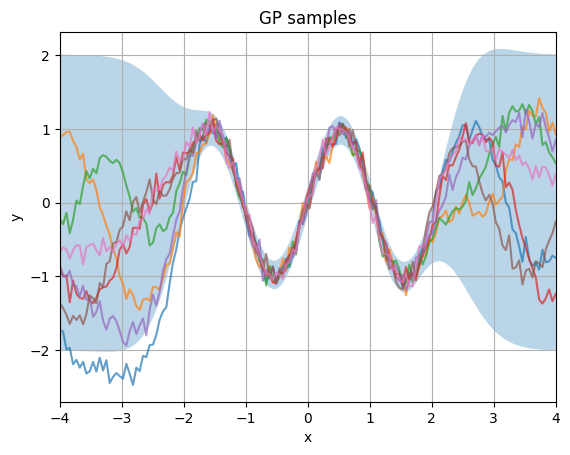

In [11]:
ymean, ycov = reg.predict(xtest[:,None],return_cov=True) #c=)
ysamps = np.random.multivariate_normal(ymean, ycov, size = 7) #c=)

plt.plot(xtest,ysamps.T,alpha=0.7)
plt.fill_between(xtest,ytest_p-2*ytest_std,ytest_p+2*ytest_std,alpha=0.3)
plt.xlim(min(xtest),max(xtest))
plt.grid(); plt.xlabel('x'); plt.ylabel('y'); plt.title('GP samples')
plt.show()

**d)** Repeat the exercise trying out some other kernels provided in sklearn [Kernels](https://scikit-learn.org/stable/modules/gaussian_process.html#kernel-operators), for instance, the Exp-Sine-Squared kernel (`ExpSineSquared`).

As seen in the implementation solving a GP requires solving a system of equations of $A x = y$ with a $A$ a shape of `(Nsamp,Nsamp)` which scales badly with an increasing data size. 

**e)** Measure the time it takes to estimate a model for different dataset sizes for `range(100,2500,200)` and save the time it takes to an array. Observe the scaling by plotting these saved times. (this computation should not take more than a minute)

*Tip: use time.time() to get the current time in seconds from the time module*

**f)** How does the computation time scale with the number of samples (linear or worse?)

**Answer f):** The computational cost grows with $\mathcal{O}(n^3)$, this is especially visible for high dataset sizes.

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared
import numpy as np
def test(Nsamples):
    N = Nsamples
    noise = 0.1
    f0 = lambda x: np.sin(3*x)

    x = np.random.normal(loc=0,scale=0.8,size=N)
    y = f0(x) + noise*np.random.normal(loc=0,scale=0.9,size=x.shape)

    reg = GaussianProcessRegressor(RBF(length_scale=1) + WhiteKernel(noise_level=1.0)) 
    reg.fit(x[:,None],y) 
    return reg

import time
Nsamples_list = range(100,2500,200)
time_list = [] #e)
for Nsamples in Nsamples_list: #e)
    t_start = time.time() #e)
    test(Nsamples) #e)
    time_elapsed = time.time() - t_start #e)
    print(Nsamples, time_elapsed,'seconds') #e)
    time_list.append(time_elapsed) #e)

100 0.0326228141784668 seconds
300 0.1418018341064453 seconds
500 0.3847465515136719 seconds
700 0.856400728225708 seconds
900 1.7883086204528809 seconds
1100 2.6119699478149414 seconds
1300 3.399158000946045 seconds
1500 4.3419029712677 seconds
1700 6.791943788528442 seconds
1900 10.002870321273804 seconds
2100 11.652111291885376 seconds
2300 18.941283226013184 seconds


where N'=N/2000


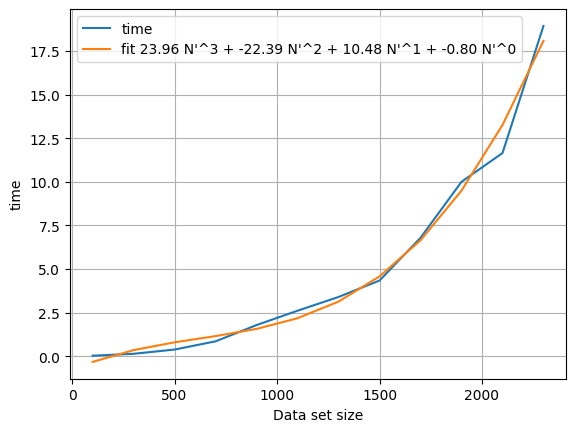

In [13]:
#plotting here
plt.plot(Nsamples_list,time_list) #e)
p = np.polyfit(Nsamples_list,time_list,3) #poly fit #e)
f = lambda x: p[0]*x**3 + p[1]*x**2 + p[2]*x + p[3] #e)
plt.plot(Nsamples_list,[f(n) for n in Nsamples_list]) #e)
comps = " + ".join([f"{pi*2000**(3-i):.2f} N'^{3-i}" for i,pi in enumerate(p)]) #e)
plt.legend(['time',f'fit {comps}']) #e)
print("where N'=N/2000") #e)
plt.grid(); plt.xlabel('Data set size'); plt.ylabel('time') #e)
plt.show() #e)
#here the x**3 term is dominant at N=2000  #e)


## (optional) Exercise 4: Designing custom Kernels

One can also construct custom kernels using physical insight. For instance, if we know that the data has the following structure

$y = a(x) x + e = f_0(x) + e$

where $a(x)$ is a smooth function, we can construct the kernel by investigating the covariance between two points as follows:

$$\text{Cov}(y_i,y_j) = x_i  x_j + \delta_{ij} \sigma_e^2$$

Since we know $a(x)$ is a smooth function we can now set $\text{Cov}(a(x_i),a(x_j)) = k_{RBF} (x_i, x_j) x_j $ which gives the following GP prior:

$$
p\left (
Y_*
 \right ) = \mathcal{N}\left(Y_* \mid 
0
,\text{Cov}(Y,Y) \right )
$$

$$
p\left (
Y
 \right ) = \mathcal{N}\left(Y \mid 
0
,X \cdot k_\text{RBF}(X,X) \cdot X + I \sigma_e^2 \right )
$$
where
$$
[X \cdot k_\text{RBF}(X,X) \cdot X]_{ij} = x_i k_{RBF} (x_i, x_j) x_j
$$


**a)** What are the main characterstics of these prior functions? Lastly, why are these characterstics expected given the kernel?

**Answer a):** The sampled functions from the prior distribution goes through zero, the functions are quite smooth and the function grow at the same speed as a linear function with slope $1$ or $-1$. The functions passes through zero since both the mean and covariance are (almost) zero in zero, it is smooth since we use a RBF kernel for $\text{Cov}(a,a)$ and is bounded by a slope of one since the RBF has a amplitude of $1$. 

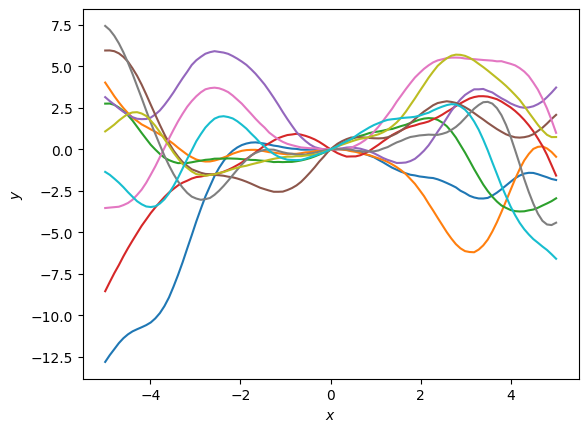

In [14]:
import numpy as np
from matplotlib import pyplot as plt

def kernel_RBF(x1, x2, kernel_width = 1):
    diff = x1[:,None] - x2[None,:]
    return np.exp(- diff**2/(2*kernel_width))

def kernelyy(x1, x2, kernel_width = 1):
    A = kernel_RBF(x1, x2, kernel_width=kernel_width)
    #or np.einsum('i,ij,j->ij', x1, A, x2)
    return x1[:,None]*A*x2[None,:] 

noise_level = 1e-2 

X = np.linspace(-5,5,100)
kernel_width = 1
K = kernelyy(X, X, kernel_width=kernel_width) + np.eye(len(X))*noise_level**2 
mu = np.zeros(len(X))

Y_samples = np.random.multivariate_normal(mu, K , size=10)
 
plt.plot(X, Y_samples.T)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Like always this is now a valid kernel and can be used as such


$$
p\left (\left[\begin{array}{l}
Y_N \\
f_0(X_*)
\end{array}\right] \right ) = \mathcal{N}\left(\left[\begin{array}{l}
Y_N \\
f_0(X_*)
\end{array}\right] \mid \left[\begin{array}{l}
0 \\
0
\end{array}\right],\left[\begin{array}{cc}
K_{XX} + I_* \sigma_e^2& K_{X X_*} \\
K_{X_* X} & K_{X_* X_*} 
\end{array}\right]\right)
$$

where we can compute 
$$
p(f_0(X_*) | Y_N)
$$
with the conventional methods.


kernel_width= 2.559547922699533


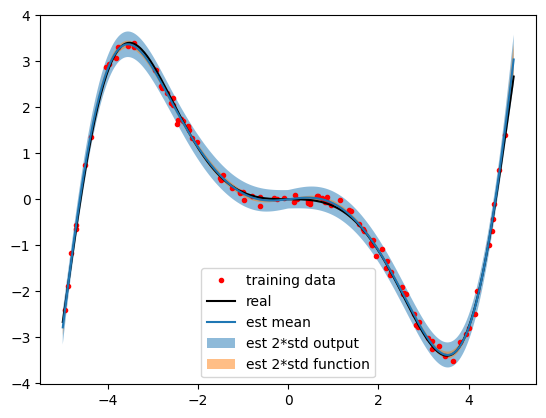

In [15]:
#data generation:
X_N = np.random.uniform(low=-5, high=5, size = 100)
areal = lambda X_N: np.sin(-(X_N**2)/(2*1.5**3))
noise_level = 1e-1
Y_N = areal(X_N)*X_N + np.random.normal(scale=noise_level, size=len(X_N))

#X_*:
x_test = np.linspace(-5, 5, 300)

def meannegloglikelihood(Y_N, mu, K): #K of the standard deviation
    N = len(Y_N)
    norm_term =  N/2*np.log(2*np.pi) 
    complexity_term = 0.5*np.linalg.slogdet(K)[1] 
    data_term = 0.5*(Y_N-mu)@np.linalg.inv(K)@(Y_N-mu)

    loglikelihood = -(norm_term + data_term + complexity_term)
    return -loglikelihood/N

#kernel_width optimization with a grid search:
res = []
kernel_widths = np.geomspace(1e-4, 1e4,)
for kernel_width in kernel_widths:
    K_YY = kernelyy(X_N, X_N, kernel_width=kernel_width) + np.eye(len(X_N))*noise_level**2
    mu_YY = np.zeros(len(X_N))
    res.append(meannegloglikelihood(Y_N, mu_YY, K_YY))
kernel_width = kernel_widths[np.argmin(res)]
print('kernel_width=',kernel_width)



K_YY = kernelyy(X_N, X_N, kernel_width=kernel_width) + np.eye(len(X_N))*noise_level**2
K_YS = kernelyy(X_N, x_test, kernel_width=kernel_width)
K_SY = kernelyy(x_test, X_N, kernel_width=kernel_width)
K_SS = kernelyy(x_test, x_test, kernel_width=kernel_width)

mu_post = K_SY@np.linalg.inv(K_YY)@Y_N
cov_mean_post = K_SS - K_SY@np.linalg.inv(K_YY)@K_YS
std_mean_post = np.diag(cov_mean_post)**0.5
std_post = std_mean_post + noise_level

plt.plot(X_N, Y_N, 'r.')
plt.plot(x_test, areal(x_test)*x_test ,'k')
plt.plot(x_test, mu_post)
plt.fill_between(x_test, mu_post - std_post*2, mu_post + std_post*2, alpha=0.5)
plt.fill_between(x_test, mu_post - std_mean_post*2, mu_post + std_mean_post*2, alpha=0.5)
plt.legend(['training data','real','est mean','est 2*std output','est 2*std function'])
plt.show()

Something interesting that you can do with this kernel is that you can also obtain the distribution of $a(x)$. We can write out the following covariance:

$$\text{Cov}(y_i, a(x_j)) = \text{Cov}(a(x_i) x_i + e_i, a(x_j))$$

$$ = \text{Cov}(a(x_i) , a(x_j)) x_i$$

$$ = k_\text{RBF}(x_i,x_j) x_i$$

Hence we can write:

$$
p\left (\left[\begin{array}{l}
Y_N \\
a(X_*)
\end{array}\right] \right ) = \mathcal{N}\left(\left[\begin{array}{l}
Y_N \\
a(X_*)
\end{array}\right] \mid \left[\begin{array}{l}
0 \\
0
\end{array}\right],\left[\begin{array}{cc}
\text{Cov}(Y_N, Y_N) &  \text{Cov}(Y_N, a(X_*))\\
\text{Cov}(Y_*, a(X_N)) & \text{Cov}(a(X_*), a(X_*))
\end{array}\right]\right)
$$

$$
p\left (\left[\begin{array}{l}
Y_N \\
a(X_*)
\end{array}\right] \right ) = \mathcal{N}\left(\left[\begin{array}{l}
Y_N \\
a(X_*)
\end{array}\right] \mid \left[\begin{array}{l}
0 \\
0 
\end{array}\right],\left[\begin{array}{cc}
X_N \cdot k_\text{RBF}(X_N,X_N) \cdot X_N + I_* \sigma_e^2&  k_\text{RBF}(X_N,X_*) \cdot X_N\\
X_* \cdot k_\text{RBF}(X_*,X_N) & k_\text{RBF}(X_*,X_*)
\end{array}\right]\right)
$$

This means that you can compute  $p(a(X_*)|Y_N)$ using conventional methods.




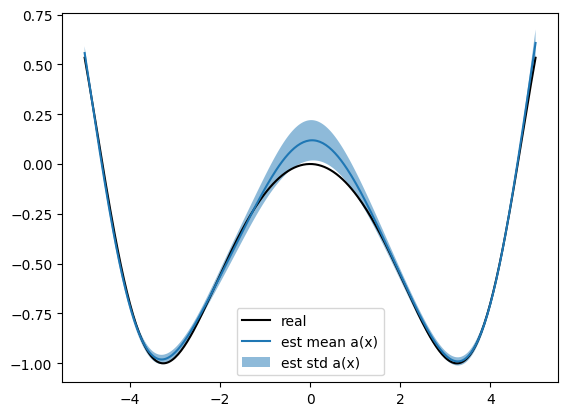

In [16]:
def kernelya(x1, x2, kernel_width = 1):
    A = kernel_RBF(x1, x2, kernel_width=kernel_width)
    return np.einsum('i,ij->ij', x1, A)

def kernelay(x1, x2, kernel_width = 1):
    A = kernel_RBF(x1, x2, kernel_width=kernel_width)
    return np.einsum('ij,j->ij', A, x2)

def kernelaa(x1, x2, kernel_width = 1):
    return kernel_RBF(x1, x2, kernel_width=kernel_width)

K_YY = kernelyy(X_N, X_N, kernel_width=kernel_width) + np.eye(len(X_N))*noise_level**2
K_YA = kernelya(X_N, x_test, kernel_width=kernel_width)
K_AY = kernelay(x_test, X_N, kernel_width=kernel_width)
K_AA = kernelaa(x_test, x_test, kernel_width=kernel_width)

mu_post = K_AY@np.linalg.inv(K_YY)@Y_N
cov_post = K_AA - K_AY@np.linalg.inv(K_YY)@K_YA
std_post = np.diag(cov_post)**0.5
plt.plot(x_test, areal(x_test),'k')
plt.plot(x_test, mu_post)
plt.fill_between(x_test, mu_post - std_post*2, mu_post + std_post*2, alpha=0.5)
plt.legend(['real','est mean a(x)','est std a(x)'])
plt.show()

## Exercise 5: NARX GP

In the previous exercise, we explored how Gaussian Processes (GPs) can be used to estimate non-linear models. Let's apply GPs to the same example we used in the previous exercise set (Week 1).

**a)** Construct the data arrays `Xtrain, Xval, Ytrain, Yval` using the cell below and estimate a GP with RBF and white kernel. Make a residual plot of both the training and validation data. Also include the uncertainty in the residual plot as a bar plot ([matplotlib errorbar plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html))


In [17]:
import numpy as np
from matplotlib import pyplot as plt
def f(upast,ypast):
    ukm2, ukm1 = upast
    ykm2, ykm1 = ypast
    ystar = (0.8 - 0.5 * np.exp(-ykm1 ** 2)) * ykm1 - (0.3 + 0.9 * np.exp(-ykm1 ** 2)) * ykm2 \
           + ukm1 + 0.2 * ukm2 + 0.1 * ukm1 * ukm2
    return ystar + np.random.normal(scale=0.01)

def use_NARX_model_in_simulation(ulist, f, na, nb):
    #init upast and ypast as lists.
    upast = [0]*nb 
    ypast = [0]*na 
    
    ylist = []
    for unow in ulist:
        #compute the current y given by f
        ynow = f(upast,ypast) 
        
        #update past arrays
        upast.append(unow)
        upast.pop(0)
        ypast.append(ynow)
        ypast.pop(0)
        
        #save result
        ylist.append(ynow)
    return np.array(ylist) #return result

na, nb = 2, 2

np.random.seed(42)
N = 500
ulist = np.random.normal(scale=1,size=N)
ylist = use_NARX_model_in_simulation(ulist,f,na,nb)

def make_training_data(ulist,ylist,na,nb):
    #Xdata = (Nsamples,Nfeatures)
    #Ydata = (Nsamples)
    Xdata = []
    Ydata = []
    #for loop over the data:
    for k in range(max(na,nb),len(ulist)): #skip the first few indexes such to 
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]])) 
        Ydata.append(ylist[k]) 
    return np.array(Xdata), np.array(Ydata)

split = 0.75 #75% training and 25% validation split
split_index = int(len(ulist)*split) 
Xtrain, Ytrain = make_training_data(ulist[:split_index],ylist[:split_index], na, nb) 
Xval,   Yval   = make_training_data(ulist[split_index:],ylist[split_index:], na, nb)
print('Xtrain.shape',Xtrain.shape)
print('Xval.shape',Xval.shape)

Xtrain.shape (373, 4)
Xval.shape (123, 4)


In [18]:
#fitting
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared

ker = RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01) #a=)
reg = GaussianProcessRegressor(ker, n_restarts_optimizer=10) #a=)
reg.fit(Xtrain,Ytrain) #a)

GaussianProcessRegressor(kernel=RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=10)

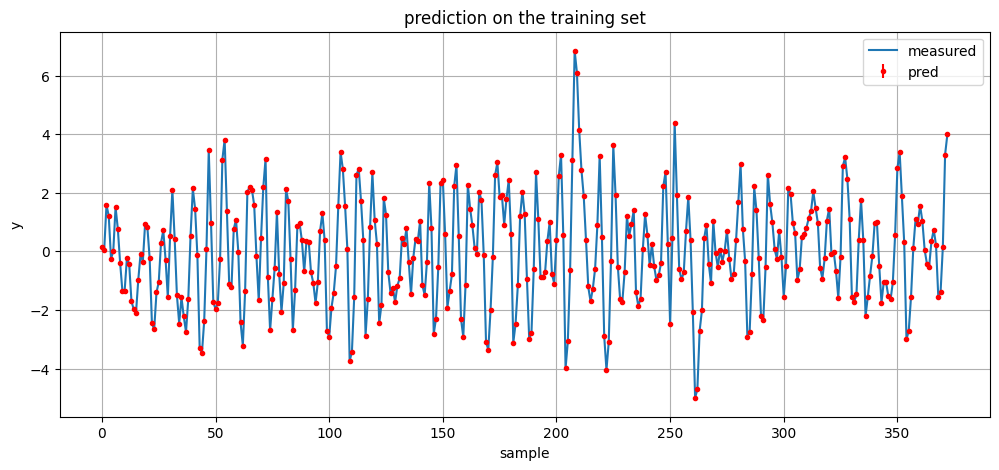

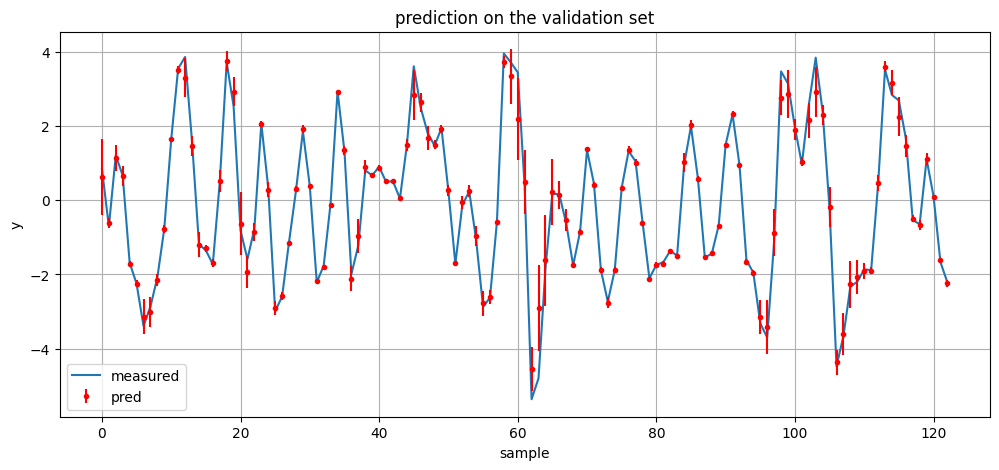

Validation NRMS= 0.1366138801241127


In [19]:
#residual calculations and plotting
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain,return_std=True) #a)
plt.figure(figsize=(12,5)) #a)
plt.plot(Ytrain) #a)
plt.title('prediction on the training set')
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain,return_std=True) #a)
plt.errorbar(np.arange(len(Xtrain)), (Ytrain_pred), yerr=2*Ytrain_pred_std,fmt='.r') #a)
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred'])#a)
plt.show() #a)

plt.figure(figsize=(12,5)) #a)
plt.title('prediction on the validation set')
plt.plot(Yval) #a)
Yval_pred, Yval_pred_std = reg.predict(Xval,return_std=True) #a)
plt.errorbar(np.arange(len(Xval)), (Yval_pred), yerr=2*Yval_pred_std,fmt='.r') #a)
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred']) #a)
plt.show() #a)

print(f'Validation NRMS= {np.mean((Yval_pred-Yval)**2)**0.5/np.std(Yval)}')#a)

**b)** We are also interested in the simulation performance of the model. Make a simulation and plot the residual and the NRMS. Is it lower than the polynomial model of the last exercise set?

**c)** Retry the exercise with different kernels and see if you can construct a kernel that is more accurate.

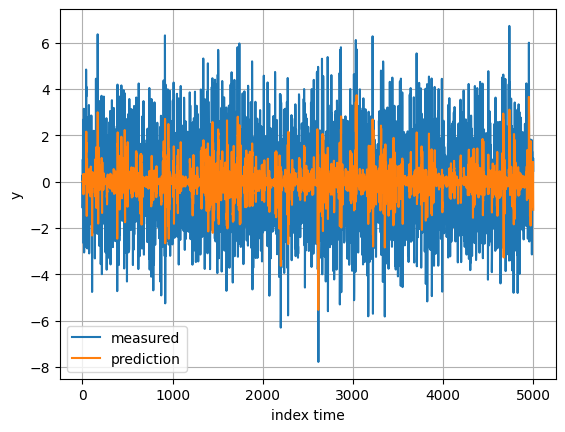

NRMS= 0.3100064489119389


In [20]:
np.random.seed(43)
utest = np.random.normal(scale=1.0,size=5000)
ytest = use_NARX_model_in_simulation(utest,f,na,nb)


model_now = reg #b=)
fmodel = lambda u,y: model_now.predict(np.concatenate([u,y])[None,:])[0] 
ytest_sim = use_NARX_model_in_simulation(utest, fmodel, na, nb)
plt.plot(ytest) #b)
plt.plot(ytest-ytest_sim) #b)
plt.grid(); plt.xlabel('index time'); plt.ylabel('y'); plt.legend(['measured','prediction']) #b)
plt.show() #b)

print('NRMS=',np.mean((ytest-ytest_sim)**2)**0.5/np.std(ytest)) #b)


## Exercise 6: Bayesian optimization


In this exercise, we will explore the basics of Bayesian optimization. Consider the same setting as in Exercise 2, but now with a slightly modified problem setting as seen below. 

**a)** For a given set of 1-dimensional inputs and outputs estimate a GP regressor in `get_model` with an `RBF` kernel and a `WhiteKernel`. Also, write `get_mean_std` which returns the mean and the standard deviation for a given regressor and test points.

**b)** Write the acquisition variance (`acquisition_var`) which takes in a number of test points and returns the estimated quality of picking each point based on the variance. 

**c)** Write the main `bayesian_optimization` function which in the first part samples `f` uniformly on the interval of `xmin` to `xmax` for `n_initial` points. Afterward, it should use the maximum of `acquisition_fun` (using `xtest_points`) to sample `f`  until having `n_max` points. Define the test set as `xtest = np.linspace(-3,3,num=1000)`. Visualize the results using the plotting already present below. 

*Tip: use np.argmax and np.append*

**d)** Implement an acquisition function that weights the mean and the variance given by $\mu(x) (1-w) + \sigma(x) w$ which aims to find the maximum of the function while incorporating the variance of the function as well for exploration. Implement the `acquisition_weighted_mean_and_var` function and switching `have_d_been_implemented` to True. How does the behavior change for different values of $w$?

There are many options for acquisition function, Further reading: https://distill.pub/2020/bayesian-optimization/


Variance Acquision


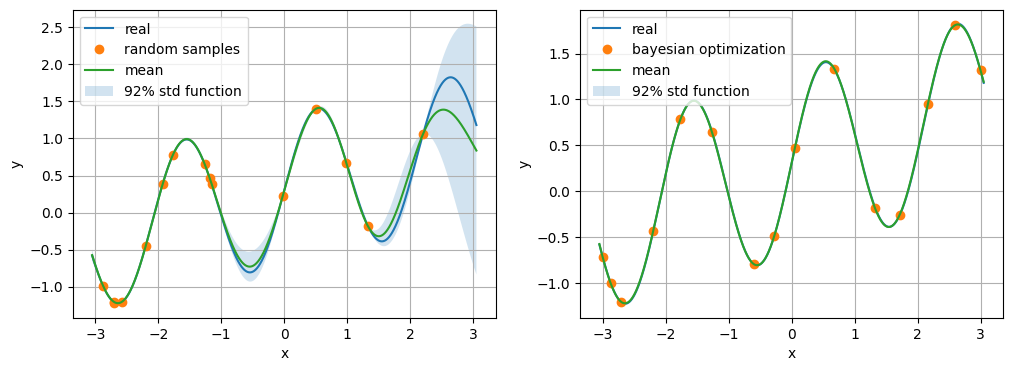

Weighted mean and Variance Acquision (weight=0.8)


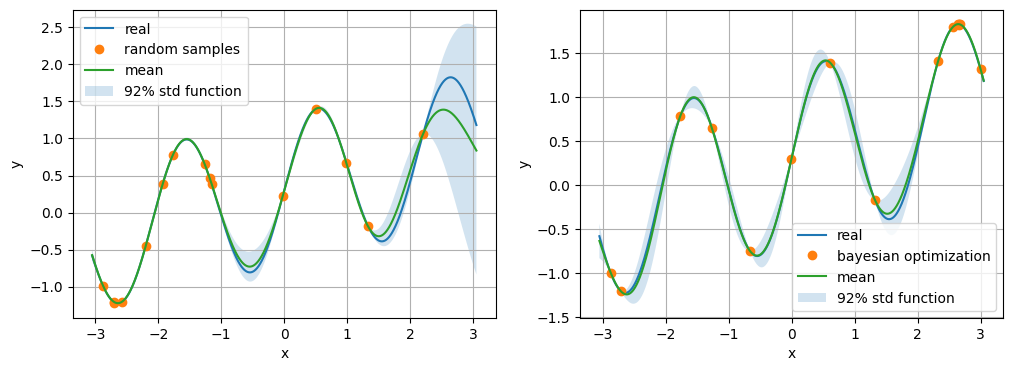

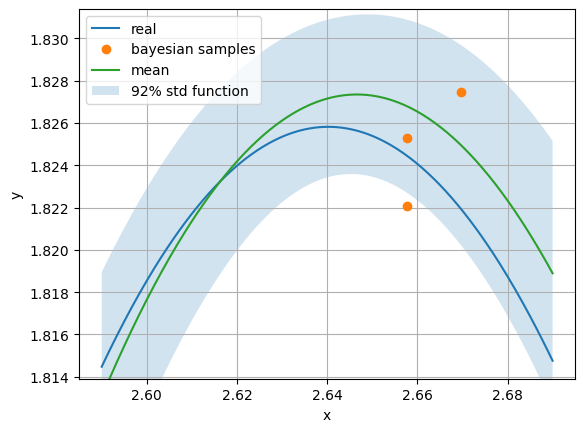

In [21]:
import warnings
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, ConstantKernel
import numpy as np
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore") #This line suppresses warning messages during code execution.

if True: #You can change the function to observe different behaviour.
    f0 = lambda x: np.sin(3*x) + 0.2*x + 0.3 #without noise
    xmin, xmax = -3., 3.
else:
    f0 = lambda x: x/20+x**2-x**4+np.exp(-(20*x)**2)/4
    xmin, xmax = -1., 1.
f = lambda x: f0(x) + np.random.normal(scale=0.005,size=np.array(x).shape) #noisy version

def get_model(x,y): 
    #return a regressor which is fitted to x,y
    ker = RBF(length_scale=0.4,length_scale_bounds=(0.01,5.0)) + \
          WhiteKernel(noise_level=1e-6,noise_level_bounds=(1e-8,1e-2)) #a)
    gp_reg = GaussianProcessRegressor(ker, n_restarts_optimizer=10) #a)
    gp_reg.fit(x[:,None],y) #a)
    return gp_reg #a)

def get_mean_std(gp_reg, xtest_points):
    ytest_pred_mean, ytest_pred_std = gp_reg.predict(xtest_points[:,None],return_std=True) #a)
    ytest_std_mean = (ytest_pred_std**2 - np.exp(gp_reg.kernel_.k2.theta))**0.5
    return ytest_pred_mean, ytest_std_mean
    
def acquisition_var(gp_reg, xtest_points):
    ytest_pred_mean, ytest_pred_std = get_mean_std(gp_reg, xtest_points) #b)
    return ytest_pred_std**2 #b)

def acquisition_weighted_mean_and_std(gp_reg, xtest_points, weight=0.5):
    pass
    ytest_pred_mean, ytest_pred_std_mean = get_mean_std(gp_reg, xtest_points) #d)    
    return (1-weight)*ytest_pred_mean + weight*ytest_pred_std_mean #d)

def bayesian_optimization(f, xmin, xmax, acquisition_fun, n_initial=5, n_max=15, seed=22):
    # f : is the function which need to be sampled
    # xmin : and xmax are the bounds on the x
    # acquisition_fun(gp_reg, some_x_points) : is the acquisition_fun on which the maximum need to be chosen as next point
    # n_initial : the number of points which are uniformly sampled from f before using bayesian optimizaiton
    # n_max : the buget of the number of maximum points that can be sampled from f 
    # (i.e. n_initial - n_max is the number of bayesian samples)
    
    rng = np.random.RandomState(seed) #you can use rng as a random generator, (e.g. rng.uniform(xmin, xmax) will sample uniform)
    x = rng.uniform(xmin, xmax, size=n_initial) #c=)
    y = f(x) #c=)
    xtest_points = np.linspace(xmin, xmax, num=1000) #c=)
    for n in range(n_initial+1, n_max+1): #c)
        gp_reg = get_model(x,y)
        acquisition_vals = acquisition_fun(gp_reg, xtest_points) #c=)
        xnew = xtest_points[np.argmax(acquisition_vals)] #c=)
        ynew = f(xnew) #c=)
        x = np.append(x,xnew) #c=)
        y = np.append(y,ynew) #c=)
    return x, y, get_model(x,y)

n_initial = 5
n_max = 15

rng = np.random.RandomState(21)
x_rand = rng.uniform(xmin, xmax, size=n_max) #random baseline
y_rand = f(x_rand)
x_test = np.linspace(xmin-0.05,xmax+0.05,num=5000)

have_d_been_implemented = True  #switch to true when working on **d)**
if have_d_been_implemented:
    weight = 0.8
    #incorporate the weight factor in the function with a lambda function
    acquisition_weighted_mean_and_std_now = lambda gp_reg, xtest_points: \
        acquisition_weighted_mean_and_std(gp_reg, xtest_points, weight=weight)
else:
    acquisition_weighted_mean_and_var_now = None
    
for mode,acquisition_fun in enumerate([acquisition_var,acquisition_weighted_mean_and_std_now]):
    if acquisition_fun==None:
        continue
    if mode==0:
        print('Variance Acquision')
    else:
        print(f'Weighted mean and Variance Acquision (weight={weight})')
    #Bayesian
    x, y, reg = bayesian_optimization(f, xmin, xmax, acquisition_fun=acquisition_fun, n_initial=n_initial, n_max=n_max, seed=21)

    plt.figure(figsize=(12,4))
    for i,(xi, yi) in enumerate([(x_rand,y_rand),(x,y)]):
        plt.subplot(1,2,i+1)
        plt.plot(x_test,f0(x_test),label='real')

        label = 'random samples' if i==0 else 'bayesian optimization'
        plt.plot(xi,yi,'o',label=label)

        reg = get_model(xi,yi)

        ytest_pred_mean, ytest_pred_std_mean = get_mean_std(reg, x_test)
        plt.plot(x_test, ytest_pred_mean,label='mean')
        plt.fill_between(x_test, \
                         ytest_pred_mean+1.92*ytest_pred_std_mean,\
                         ytest_pred_mean-1.92*ytest_pred_std_mean,\
                         alpha=0.2,label='92% std function')
        plt.grid()
        plt.legend()
        plt.ylabel('y')
        plt.xlabel('x')
    plt.show()
    
    if mode==1:
        M = x_test[np.argmax(f0(x_test))]
        x_near = np.linspace(M-0.05, M+0.05,num=300)
        ytest_pred_mean, ytest_pred_std_mean = get_mean_std(reg, x_near)
        
        plt.plot(x_near, f0(x_near),label='real')
        xlim, ylim = plt.xlim(), plt.ylim()
        plt.plot(xi,yi,'o',label='bayesian samples')
        plt.plot(x_near, ytest_pred_mean,label='mean')
        plt.fill_between(x_near, \
                         ytest_pred_mean+1.92*ytest_pred_std_mean,\
                         ytest_pred_mean-1.92*ytest_pred_std_mean,\
                         alpha=0.2,label='92% std function')
        plt.xlim(xlim); plt.ylim(ylim[0],ylim[1]+0.005)
        plt.legend()
        plt.grid()
        plt.ylabel('y')
        plt.xlabel('x')
        plt.show()



The grid-based optimization that we used above is not guaranteed to find the global
optimum of the selection problem precisely, neither is it applicable in case of high-dimensional regression spaces.
Hence, in case of a professional implementation a maximization over the acqusiation function is implemented as a nonlinear optimisation problem which can be solved by gradient-based techniques or by swarm optimization. Bayesian optimisation is a powerful method that can be deployed for highly complex problems and often used as a tool for selecting the hyperparameters for deep learning.


## Exercise 7: Sparse Gaussian Processes

This exercise is based on https://nbviewer.org/github/SheffieldML/notebook/blob/master/GPy/sparse_gp_regression.ipynb


**a)** install GPy by running `pip install --upgrade GPy`  https://gpy.readthedocs.io/en/deploy/index.html, https://github.com/SheffieldML/GPy

If this fails you can retry this command in the anaconda command prompt and afterwards restart the notebook. 

In [22]:
!pip install --upgrade GPy

# Note on Installing GPy:
# If installing GPy using !pip install --upgrade GPy throws an error, follow these steps:
# 1. Open Anaconda Prompt as an administrator.
# 2. Activate the 'ml4sc' environment using the command 'conda activate ml4sc'.
# 3. Re-run the command 'pip install --upgrade GPy'.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 6.9 MB/s eta 0:00:00


# Sparse GP Regression

<!-- %### 14th January 2014 James Hensman
%#### 29th September 2014 Neil Lawrence (added sub-titles, notes and some references). -->

This example shows the variational compression effect of so-called 'sparse' Gaussian processes. In particular we show how using the variational free energy framework of [Titsias, 2009](http://jmlr.csail.mit.edu/proceedings/papers/v5/titsias09a/titsias09a.pdf) we can compress a Gaussian process without signifciantly worsening its prediction capabilites. First we set up the notebook with a fixed random seed, and import GPy.

In [23]:
import GPy
import numpy as np
np.random.seed(101)

## Sample Function

Now we'll sample a Gaussian process regression problem directly from a Gaussian process prior. We'll use an exponentiated quadratic covariance function with a kernel width (length scale) of 1 and sample 50 equally spaced points. 

In [24]:
N = 50
noise_var = 0.05

X = np.linspace(0,10,50)[:,None]
k = GPy.kern.RBF(1)
y = np.random.multivariate_normal(np.zeros(N),k.K(X)+np.eye(N)*np.sqrt(noise_var)).reshape(-1,1)

## Full Gaussian Process Fit

Now we use GPy to optimize the parameters of a Gaussian process given the sampled data. Here, there are no approximations, we simply fit the full Gaussian process.


Name : GP regression
Objective : 50.11691792294765
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |  1.6316920345471586  |      +ve      |        
  rbf.lengthscale          |  1.1032687303390274  |      +ve      |        
  Gaussian_noise.variance  |  0.2364999109816964  |      +ve      |        


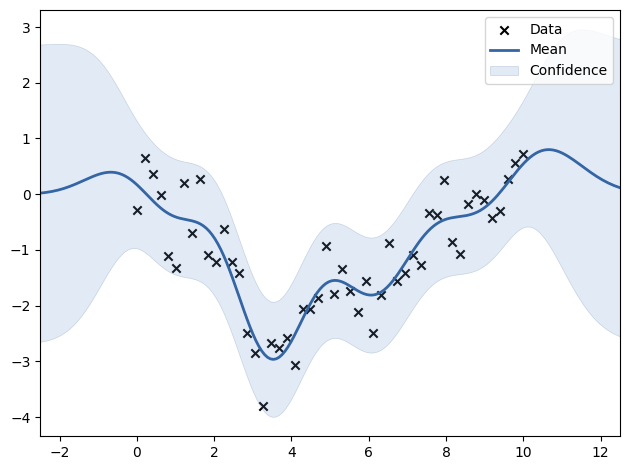

In [25]:
m_full = GPy.models.GPRegression(X,y)
m_full.optimize('bfgs')
m_full.plot()
print (m_full)

## A Poor `Sparse' GP Fit

Now we construct a sparse Gaussian process. This model uses the inducing variable approximation and initialises the inducing variables in two 'clumps'. Our initial fit uses the *correct* covariance function parameters, but a badly placed set of inducing points. 


Name : sparse_gp
Objective : 260.92079394903976
Number of Parameters : 9
Number of Optimization Parameters : 9
Updates : True
Parameters:
  sparse_gp.               |   value  |  constraints  |  priors
  inducing_inputs          |  (6, 1)  |               |        
  rbf.variance             |     1.0  |      +ve      |        
  rbf.lengthscale          |     1.0  |      +ve      |        
  Gaussian_noise.variance  |    0.05  |      +ve      |        


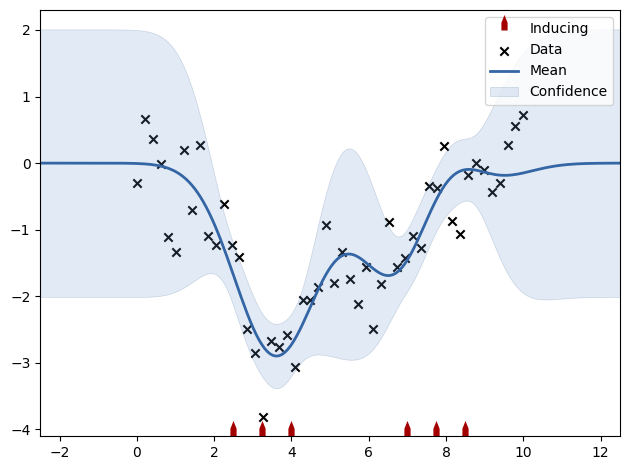

In [26]:
Z = np.hstack((np.linspace(2.5,4.,3),np.linspace(7,8.5,3)))[:,None]
m = GPy.models.SparseGPRegression(X,y,Z=Z)
m.likelihood.variance = noise_var
m.plot()
print (m)


Notice how the fit is reasonable where there are inducing points, but bad elsewhere. 

### Optimizing Covariance Parameters

Next, we will try and find the optimal covariance function parameters, given that the inducing inputs are held in their current location. 


Name : sparse_gp
Objective : 54.02423365119682
Number of Parameters : 9
Number of Optimization Parameters : 3
Updates : True
Parameters:
  sparse_gp.               |                value  |  constraints  |  priors
  inducing_inputs          |               (6, 1)  |     fixed     |        
  rbf.variance             |   1.6852838809665087  |      +ve      |        
  rbf.lengthscale          |   2.9728022742124627  |      +ve      |        
  Gaussian_noise.variance  |  0.37348007799928856  |      +ve      |        


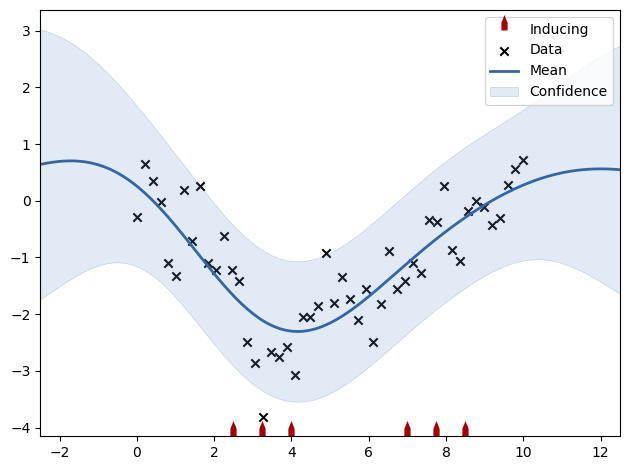

In [27]:
m.inducing_inputs.fix()
m.optimize('bfgs')
m.plot()
print (m)

The poor location of the inducing inputs causes the model to 'underfit' the data. The length scale is much longer than for the full GP, and the noise variance is larger. This is because in this case the Kullback Leibler term in the free energy objective is dominating, and requires a larger length scale to improve the quality of the approximation. This is due to the poor location of the inducing inputs. 

### Optimizing Inducing Inputs

Firstly we try optimzing the location of the inducing inputs to fix the problem, however we still get a larger length scale than the Gaussian process we sampled from (or the full GP fit we did at the beginning).

{'inducing': <matplotlib.collections.PathCollection at 0x7e41f770fbb0>,
 'dataplot': [<matplotlib.collections.PathCollection at 0x7e41f770c070>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7e41f770d7b0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7e41f770d8a0>]}

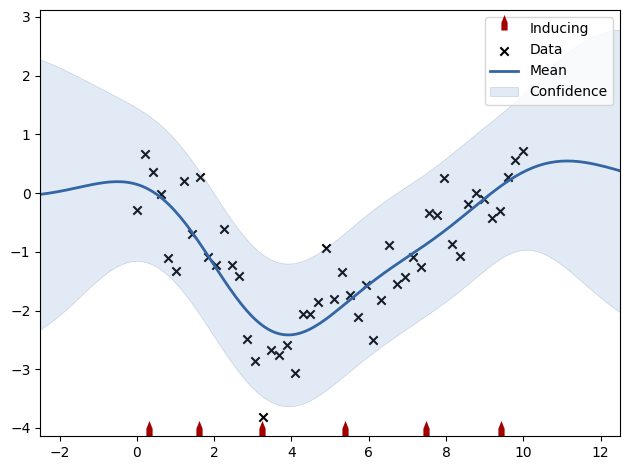

In [28]:
m.randomize()
m.Z.unconstrain()
m.optimize('bfgs')
m.plot()

The current set of inducing points provides partial coverage of the data space, but the fit remains suboptimal. To address this, we'll increase the number of inducing points 

### Train with More Inducing Points

Now we try 12 inducing points, rather than the original 6 points. We then compare with the full Gaussian process likelihood.

[[-50.14270903]] -50.11691792294765


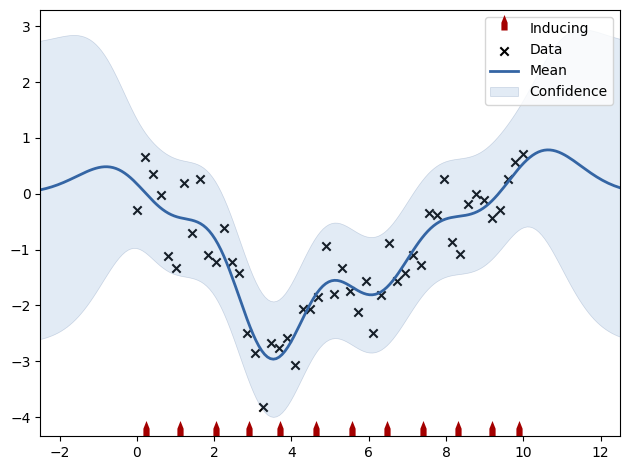

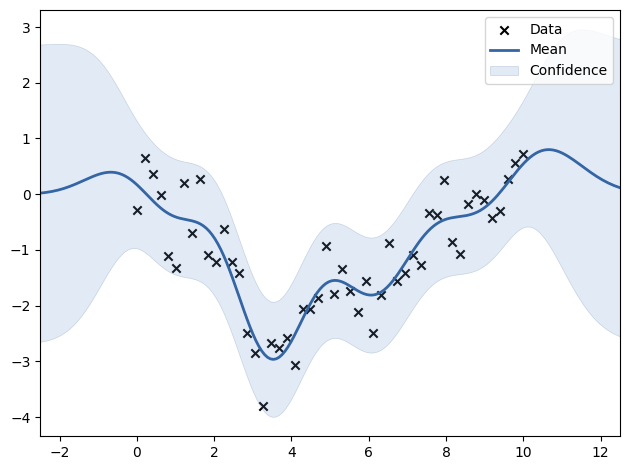

In [29]:
Z = np.random.rand(12,1)*12
m = GPy.models.SparseGPRegression(X,y,Z=Z)

m.optimize('bfgs')
m.plot()
m_full.plot()
print (m.log_likelihood(), m_full.log_likelihood())

This time, we've ensured an adequate number of inducing points, resulting in a fit closely resembling that of the GP . This is verified by the fact that the bound on the marginal likelihood is tight, which means that our variational approximation must be good (the difference between the bound and the true likelihood is the Kullback Leibler divergence between the approximation and the truth). 